<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/VAE_origin_Exp03_After1Epoch_Reduce_lr1e_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again
* Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum -> mean
* Add 
    * train, test loss plot
    * save model's state dict

* ✅ Change
    * After Training 1-Epoch,
    * Change lr: 1e-5 to 1e-3
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

In [1]:
! nvidia-smi

Wed Jul  1 09:26:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Drive Mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
# transforms module 사용해서 Image data compose
# ImageFolder를 사용해 dataload

transforms = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 transforms.Grayscale(num_output_channels=1),  # make Image to 1-dim channel
                                 transforms.ToTensor(),                        # convert a PIL Image or numpy ndarray to tensor
                                 # transforms.Normalize()
])

# make custom datasets
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform = transforms)

In [7]:
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [8]:
# data_split
# train_dataset, test_dataset

full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [9]:
# make DataLoader

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True)  #pin_memory which enables fast data transfer to CUDA-enabled GPUs

Image 출력하기

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(img, (1, 2, 0)))

    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

In [11]:
# see one element at time

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([10,  2,  3,  2, 11, 12,  3,  2,  2, 24, 19,  0, 22, 22,  8, 11])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Fakerean Allaple.A Allaple.L Allaple.A Instantaccess Lolyda.AA1 Allaple.L Allaple.A Allaple.A Yuner.A Skintrim.N Adialer.C VB.AT VB.AT Dialplatform.B Instantaccess 


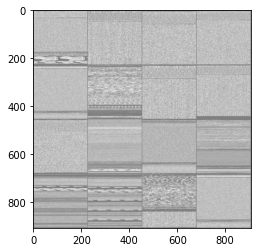

In [12]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [13]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [14]:
model = VAE().to(device)                                                
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [15]:
# After Training 1Epoch, change lr to 1e-5

optimizer = optim.Adam(model.parameters(), lr=1e-3)  

In [23]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html
PATH = './Exp03_100-Epoch.pth'

In [19]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='mean')  # changed reduction to 'mean' 
                                                                                  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    # plt.plot(train_loss / len(train_loader.dataset))
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
    torch.save(model.state_dict(), PATH)


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(16, 1, 224, 224)[:n]])
                save_image(comparison.cpu(),
                         './results_Exp03/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # plt.plot(test_loss)
    Epoch_Loss['test_epoch'].append(epoch)
    Epoch_Loss['test_loss'].append(test_loss)

In [20]:
CUDA_LAUNCH_BLOCKING=1

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 0.908095
Train Epoch: 1 [160/7471 (2%)]	Loss: 3096.798828
Train Epoch: 1 [320/7471 (4%)]	Loss: 2462.575195
Train Epoch: 1 [480/7471 (6%)]	Loss: 2390.448242
Train Epoch: 1 [640/7471 (9%)]	Loss: 1663.522095
Train Epoch: 1 [800/7471 (11%)]	Loss: 1461.587158
Train Epoch: 1 [960/7471 (13%)]	Loss: 1063.364380
Train Epoch: 1 [1120/7471 (15%)]	Loss: 815.242310
Train Epoch: 1 [1280/7471 (17%)]	Loss: 684.199646
Train Epoch: 1 [1440/7471 (19%)]	Loss: 510.407043
Train Epoch: 1 [1600/7471 (21%)]	Loss: 425.383545
Train Epoch: 1 [1760/7471 (24%)]	Loss: 300.265350
Train Epoch: 1 [1920/7471 (26%)]	Loss: 264.260284
Train Epoch: 1 [2080/7471 (28%)]	Loss: 178.555634
Train Epoch: 1 [2240/7471 (30%)]	Loss: 152.086792
Train Epoch: 1 [2400/7471 (32%)]	Loss: 224.208603
Train Epoch: 1 [2560/7471 (34%)]	Loss: 208.491486
Train Epoch: 1 [2720/7471 (36%)]	Loss: 250.291306
Train Epoch: 1 [2880/7471 (39%)]	Loss: 214.762405
Train Epoch: 1 [3040/7471 (41%)]	Loss: 189.406998
Train Ep

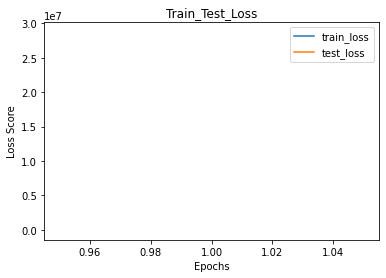

In [21]:
epochs = 1


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp03/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp03/sample_' + str(epoch) + '.png')
        

In [22]:
# After Training 1Epoch, change lr to 1e-5

optimizer = optim.Adam(model.parameters(), lr=1e-5)  

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 1.619566
Train Epoch: 1 [160/7471 (2%)]	Loss: 0.765923
Train Epoch: 1 [320/7471 (4%)]	Loss: 0.506384
Train Epoch: 1 [480/7471 (6%)]	Loss: 0.317881
Train Epoch: 1 [640/7471 (9%)]	Loss: 0.823957
Train Epoch: 1 [800/7471 (11%)]	Loss: 0.249021
Train Epoch: 1 [960/7471 (13%)]	Loss: 0.215772
Train Epoch: 1 [1120/7471 (15%)]	Loss: 0.240424
Train Epoch: 1 [1280/7471 (17%)]	Loss: 0.219033
Train Epoch: 1 [1440/7471 (19%)]	Loss: 0.196664
Train Epoch: 1 [1600/7471 (21%)]	Loss: 0.215381
Train Epoch: 1 [1760/7471 (24%)]	Loss: 0.204567
Train Epoch: 1 [1920/7471 (26%)]	Loss: 0.238128
Train Epoch: 1 [2080/7471 (28%)]	Loss: 0.355277
Train Epoch: 1 [2240/7471 (30%)]	Loss: 0.170597
Train Epoch: 1 [2400/7471 (32%)]	Loss: 0.192448
Train Epoch: 1 [2560/7471 (34%)]	Loss: 0.231427
Train Epoch: 1 [2720/7471 (36%)]	Loss: 0.170149
Train Epoch: 1 [2880/7471 (39%)]	Loss: 0.164576
Train Epoch: 1 [3040/7471 (41%)]	Loss: 0.117030
Train Epoch: 1 [3200/7471 (43%)]	Loss: 0.126667
Trai

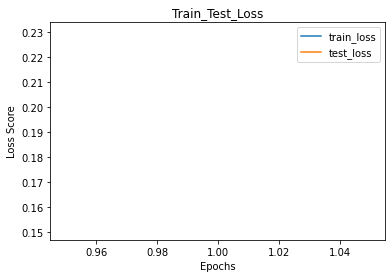

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 0.196258
Train Epoch: 2 [160/7471 (2%)]	Loss: 0.119663
Train Epoch: 2 [320/7471 (4%)]	Loss: 0.133508
Train Epoch: 2 [480/7471 (6%)]	Loss: 0.108702
Train Epoch: 2 [640/7471 (9%)]	Loss: 0.109670
Train Epoch: 2 [800/7471 (11%)]	Loss: 0.125697
Train Epoch: 2 [960/7471 (13%)]	Loss: 0.164994
Train Epoch: 2 [1120/7471 (15%)]	Loss: 0.141854
Train Epoch: 2 [1280/7471 (17%)]	Loss: 0.124403
Train Epoch: 2 [1440/7471 (19%)]	Loss: 0.134764
Train Epoch: 2 [1600/7471 (21%)]	Loss: 0.102016
Train Epoch: 2 [1760/7471 (24%)]	Loss: 0.123733
Train Epoch: 2 [1920/7471 (26%)]	Loss: 0.121721
Train Epoch: 2 [2080/7471 (28%)]	Loss: 0.110438
Train Epoch: 2 [2240/7471 (30%)]	Loss: 0.116795
Train Epoch: 2 [2400/7471 (32%)]	Loss: 0.109392
Train Epoch: 2 [2560/7471 (34%)]	Loss: 0.104006
Train Epoch: 2 [2720/7471 (36%)]	Loss: 0.157458
Train Epoch: 2 [2880/7471 (39%)]	Loss: 0.115700
Train Epoch: 2 [3040/7471 (41%)]	Loss: 0.110714
Train Epoch: 2 [3200/7471 (43%)]	Loss: 0.114402
Trai

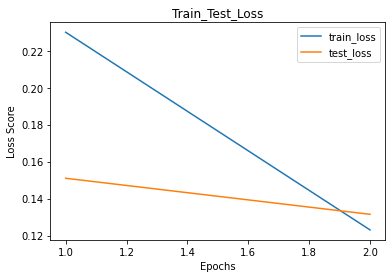

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 0.138071
Train Epoch: 3 [160/7471 (2%)]	Loss: 0.090937
Train Epoch: 3 [320/7471 (4%)]	Loss: 0.090947
Train Epoch: 3 [480/7471 (6%)]	Loss: 0.098568
Train Epoch: 3 [640/7471 (9%)]	Loss: 0.117868
Train Epoch: 3 [800/7471 (11%)]	Loss: 0.111098
Train Epoch: 3 [960/7471 (13%)]	Loss: 0.098764
Train Epoch: 3 [1120/7471 (15%)]	Loss: 0.106197
Train Epoch: 3 [1280/7471 (17%)]	Loss: 0.119755
Train Epoch: 3 [1440/7471 (19%)]	Loss: 0.168602
Train Epoch: 3 [1600/7471 (21%)]	Loss: 0.100677
Train Epoch: 3 [1760/7471 (24%)]	Loss: 0.095599
Train Epoch: 3 [1920/7471 (26%)]	Loss: 0.112448
Train Epoch: 3 [2080/7471 (28%)]	Loss: 0.095008
Train Epoch: 3 [2240/7471 (30%)]	Loss: 0.091544
Train Epoch: 3 [2400/7471 (32%)]	Loss: 0.093128
Train Epoch: 3 [2560/7471 (34%)]	Loss: 0.198857
Train Epoch: 3 [2720/7471 (36%)]	Loss: 0.086502
Train Epoch: 3 [2880/7471 (39%)]	Loss: 0.098860
Train Epoch: 3 [3040/7471 (41%)]	Loss: 0.095824
Train Epoch: 3 [3200/7471 (43%)]	Loss: 0.087807
Trai

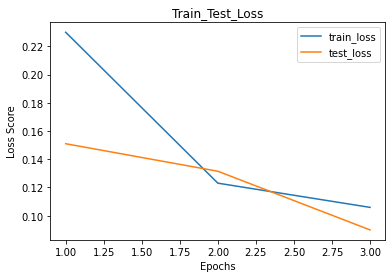

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 0.087167
Train Epoch: 4 [160/7471 (2%)]	Loss: 0.083133
Train Epoch: 4 [320/7471 (4%)]	Loss: 0.103332
Train Epoch: 4 [480/7471 (6%)]	Loss: 0.111471
Train Epoch: 4 [640/7471 (9%)]	Loss: 0.174898
Train Epoch: 4 [800/7471 (11%)]	Loss: 0.107861
Train Epoch: 4 [960/7471 (13%)]	Loss: 0.113094
Train Epoch: 4 [1120/7471 (15%)]	Loss: 0.099143
Train Epoch: 4 [1280/7471 (17%)]	Loss: 0.104069
Train Epoch: 4 [1440/7471 (19%)]	Loss: 0.091549
Train Epoch: 4 [1600/7471 (21%)]	Loss: 0.115609
Train Epoch: 4 [1760/7471 (24%)]	Loss: 0.123807
Train Epoch: 4 [1920/7471 (26%)]	Loss: 0.117191
Train Epoch: 4 [2080/7471 (28%)]	Loss: 0.090283
Train Epoch: 4 [2240/7471 (30%)]	Loss: 0.095012
Train Epoch: 4 [2400/7471 (32%)]	Loss: 0.094627
Train Epoch: 4 [2560/7471 (34%)]	Loss: 0.149860
Train Epoch: 4 [2720/7471 (36%)]	Loss: 0.084471
Train Epoch: 4 [2880/7471 (39%)]	Loss: 0.074655
Train Epoch: 4 [3040/7471 (41%)]	Loss: 0.078103
Train Epoch: 4 [3200/7471 (43%)]	Loss: 0.128448
Trai

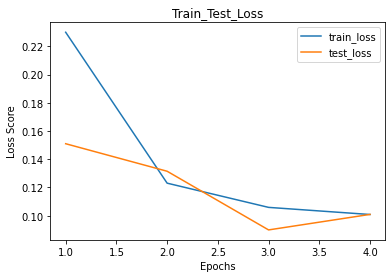

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 0.104148
Train Epoch: 5 [160/7471 (2%)]	Loss: 0.094646
Train Epoch: 5 [320/7471 (4%)]	Loss: 0.095185
Train Epoch: 5 [480/7471 (6%)]	Loss: 0.104998
Train Epoch: 5 [640/7471 (9%)]	Loss: 0.104966
Train Epoch: 5 [800/7471 (11%)]	Loss: 0.085722
Train Epoch: 5 [960/7471 (13%)]	Loss: 0.105499
Train Epoch: 5 [1120/7471 (15%)]	Loss: 0.087611
Train Epoch: 5 [1280/7471 (17%)]	Loss: 0.090737
Train Epoch: 5 [1440/7471 (19%)]	Loss: 0.095154
Train Epoch: 5 [1600/7471 (21%)]	Loss: 0.137849
Train Epoch: 5 [1760/7471 (24%)]	Loss: 0.085122
Train Epoch: 5 [1920/7471 (26%)]	Loss: 0.117119
Train Epoch: 5 [2080/7471 (28%)]	Loss: 0.098202
Train Epoch: 5 [2240/7471 (30%)]	Loss: 0.114996
Train Epoch: 5 [2400/7471 (32%)]	Loss: 0.081202
Train Epoch: 5 [2560/7471 (34%)]	Loss: 0.087810
Train Epoch: 5 [2720/7471 (36%)]	Loss: 0.105612
Train Epoch: 5 [2880/7471 (39%)]	Loss: 0.106268
Train Epoch: 5 [3040/7471 (41%)]	Loss: 0.103699
Train Epoch: 5 [3200/7471 (43%)]	Loss: 0.086523
Trai

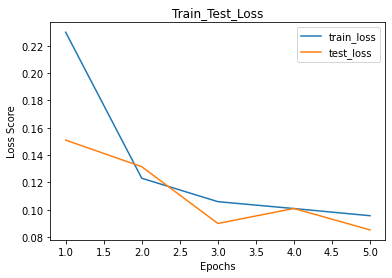

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 0.081983
Train Epoch: 6 [160/7471 (2%)]	Loss: 0.086936
Train Epoch: 6 [320/7471 (4%)]	Loss: 0.085286
Train Epoch: 6 [480/7471 (6%)]	Loss: 0.077300
Train Epoch: 6 [640/7471 (9%)]	Loss: 0.083523
Train Epoch: 6 [800/7471 (11%)]	Loss: 0.120026
Train Epoch: 6 [960/7471 (13%)]	Loss: 0.095031
Train Epoch: 6 [1120/7471 (15%)]	Loss: 0.078847
Train Epoch: 6 [1280/7471 (17%)]	Loss: 0.104231
Train Epoch: 6 [1440/7471 (19%)]	Loss: 0.079801
Train Epoch: 6 [1600/7471 (21%)]	Loss: 0.081253
Train Epoch: 6 [1760/7471 (24%)]	Loss: 0.080341
Train Epoch: 6 [1920/7471 (26%)]	Loss: 0.124867
Train Epoch: 6 [2080/7471 (28%)]	Loss: 0.108966
Train Epoch: 6 [2240/7471 (30%)]	Loss: 0.078354
Train Epoch: 6 [2400/7471 (32%)]	Loss: 0.080924
Train Epoch: 6 [2560/7471 (34%)]	Loss: 0.115574
Train Epoch: 6 [2720/7471 (36%)]	Loss: 0.099387
Train Epoch: 6 [2880/7471 (39%)]	Loss: 0.116731
Train Epoch: 6 [3040/7471 (41%)]	Loss: 0.083501
Train Epoch: 6 [3200/7471 (43%)]	Loss: 0.096374
Trai

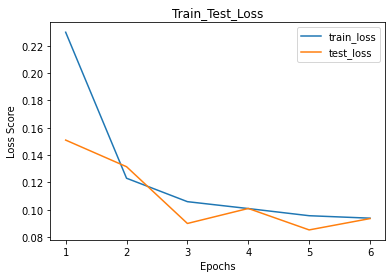

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 0.097289
Train Epoch: 7 [160/7471 (2%)]	Loss: 0.092432
Train Epoch: 7 [320/7471 (4%)]	Loss: 0.093637
Train Epoch: 7 [480/7471 (6%)]	Loss: 0.085675
Train Epoch: 7 [640/7471 (9%)]	Loss: 0.075312
Train Epoch: 7 [800/7471 (11%)]	Loss: 0.078987
Train Epoch: 7 [960/7471 (13%)]	Loss: 0.086051
Train Epoch: 7 [1120/7471 (15%)]	Loss: 0.071066
Train Epoch: 7 [1280/7471 (17%)]	Loss: 0.090908
Train Epoch: 7 [1440/7471 (19%)]	Loss: 0.080399
Train Epoch: 7 [1600/7471 (21%)]	Loss: 0.083021
Train Epoch: 7 [1760/7471 (24%)]	Loss: 0.074310
Train Epoch: 7 [1920/7471 (26%)]	Loss: 0.091215
Train Epoch: 7 [2080/7471 (28%)]	Loss: 0.084047
Train Epoch: 7 [2240/7471 (30%)]	Loss: 0.096644
Train Epoch: 7 [2400/7471 (32%)]	Loss: 0.085179
Train Epoch: 7 [2560/7471 (34%)]	Loss: 0.128869
Train Epoch: 7 [2720/7471 (36%)]	Loss: 0.106675
Train Epoch: 7 [2880/7471 (39%)]	Loss: 0.096513
Train Epoch: 7 [3040/7471 (41%)]	Loss: 0.103084
Train Epoch: 7 [3200/7471 (43%)]	Loss: 0.079878
Trai

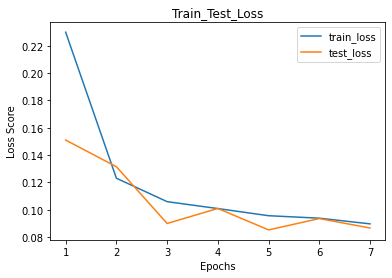

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 0.080477
Train Epoch: 8 [160/7471 (2%)]	Loss: 0.128851
Train Epoch: 8 [320/7471 (4%)]	Loss: 0.074291
Train Epoch: 8 [480/7471 (6%)]	Loss: 0.077692
Train Epoch: 8 [640/7471 (9%)]	Loss: 0.078335
Train Epoch: 8 [800/7471 (11%)]	Loss: 0.072862
Train Epoch: 8 [960/7471 (13%)]	Loss: 0.080917
Train Epoch: 8 [1120/7471 (15%)]	Loss: 0.076328
Train Epoch: 8 [1280/7471 (17%)]	Loss: 0.075762
Train Epoch: 8 [1440/7471 (19%)]	Loss: 0.082711
Train Epoch: 8 [1600/7471 (21%)]	Loss: 0.073478
Train Epoch: 8 [1760/7471 (24%)]	Loss: 0.105842
Train Epoch: 8 [1920/7471 (26%)]	Loss: 0.072319
Train Epoch: 8 [2080/7471 (28%)]	Loss: 0.071555
Train Epoch: 8 [2240/7471 (30%)]	Loss: 0.073059
Train Epoch: 8 [2400/7471 (32%)]	Loss: 0.070953
Train Epoch: 8 [2560/7471 (34%)]	Loss: 0.080082
Train Epoch: 8 [2720/7471 (36%)]	Loss: 0.080298
Train Epoch: 8 [2880/7471 (39%)]	Loss: 0.078565
Train Epoch: 8 [3040/7471 (41%)]	Loss: 0.082399
Train Epoch: 8 [3200/7471 (43%)]	Loss: 0.100598
Trai

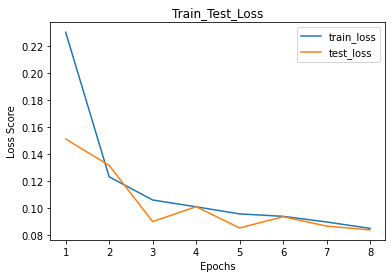

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 0.077882
Train Epoch: 9 [160/7471 (2%)]	Loss: 0.085122
Train Epoch: 9 [320/7471 (4%)]	Loss: 0.077985
Train Epoch: 9 [480/7471 (6%)]	Loss: 0.081563
Train Epoch: 9 [640/7471 (9%)]	Loss: 0.082411
Train Epoch: 9 [800/7471 (11%)]	Loss: 0.075651
Train Epoch: 9 [960/7471 (13%)]	Loss: 0.070425
Train Epoch: 9 [1120/7471 (15%)]	Loss: 0.071377
Train Epoch: 9 [1280/7471 (17%)]	Loss: 0.072687
Train Epoch: 9 [1440/7471 (19%)]	Loss: 0.114713
Train Epoch: 9 [1600/7471 (21%)]	Loss: 0.070051
Train Epoch: 9 [1760/7471 (24%)]	Loss: 0.107996
Train Epoch: 9 [1920/7471 (26%)]	Loss: 0.071342
Train Epoch: 9 [2080/7471 (28%)]	Loss: 0.090383
Train Epoch: 9 [2240/7471 (30%)]	Loss: 0.072142
Train Epoch: 9 [2400/7471 (32%)]	Loss: 0.077707
Train Epoch: 9 [2560/7471 (34%)]	Loss: 0.094098
Train Epoch: 9 [2720/7471 (36%)]	Loss: 0.078244
Train Epoch: 9 [2880/7471 (39%)]	Loss: 0.072589
Train Epoch: 9 [3040/7471 (41%)]	Loss: 0.071793
Train Epoch: 9 [3200/7471 (43%)]	Loss: 0.071845
Trai

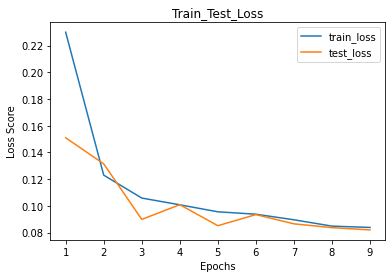

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 0.080373
Train Epoch: 10 [160/7471 (2%)]	Loss: 0.086569
Train Epoch: 10 [320/7471 (4%)]	Loss: 0.118775
Train Epoch: 10 [480/7471 (6%)]	Loss: 0.070737
Train Epoch: 10 [640/7471 (9%)]	Loss: 0.069831
Train Epoch: 10 [800/7471 (11%)]	Loss: 0.085772
Train Epoch: 10 [960/7471 (13%)]	Loss: 0.078804
Train Epoch: 10 [1120/7471 (15%)]	Loss: 0.072644
Train Epoch: 10 [1280/7471 (17%)]	Loss: 0.076881
Train Epoch: 10 [1440/7471 (19%)]	Loss: 0.073466
Train Epoch: 10 [1600/7471 (21%)]	Loss: 0.077336
Train Epoch: 10 [1760/7471 (24%)]	Loss: 0.081276
Train Epoch: 10 [1920/7471 (26%)]	Loss: 0.083134
Train Epoch: 10 [2080/7471 (28%)]	Loss: 0.070797
Train Epoch: 10 [2240/7471 (30%)]	Loss: 0.076579
Train Epoch: 10 [2400/7471 (32%)]	Loss: 0.083955
Train Epoch: 10 [2560/7471 (34%)]	Loss: 0.071732
Train Epoch: 10 [2720/7471 (36%)]	Loss: 0.108172
Train Epoch: 10 [2880/7471 (39%)]	Loss: 0.079329
Train Epoch: 10 [3040/7471 (41%)]	Loss: 0.079664
Train Epoch: 10 [3200/7471 (43%

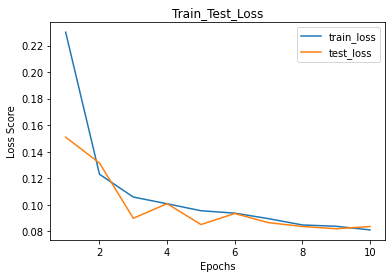

11
Train Epoch: 11 [0/7471 (0%)]	Loss: 0.077383
Train Epoch: 11 [160/7471 (2%)]	Loss: 0.082845
Train Epoch: 11 [320/7471 (4%)]	Loss: 0.072472
Train Epoch: 11 [480/7471 (6%)]	Loss: 0.071573
Train Epoch: 11 [640/7471 (9%)]	Loss: 0.088994
Train Epoch: 11 [800/7471 (11%)]	Loss: 0.071388
Train Epoch: 11 [960/7471 (13%)]	Loss: 0.076121
Train Epoch: 11 [1120/7471 (15%)]	Loss: 0.074417
Train Epoch: 11 [1280/7471 (17%)]	Loss: 0.075865
Train Epoch: 11 [1440/7471 (19%)]	Loss: 0.100150
Train Epoch: 11 [1600/7471 (21%)]	Loss: 0.082616
Train Epoch: 11 [1760/7471 (24%)]	Loss: 0.074549
Train Epoch: 11 [1920/7471 (26%)]	Loss: 0.080234
Train Epoch: 11 [2080/7471 (28%)]	Loss: 0.086165
Train Epoch: 11 [2240/7471 (30%)]	Loss: 0.089135
Train Epoch: 11 [2400/7471 (32%)]	Loss: 0.084615
Train Epoch: 11 [2560/7471 (34%)]	Loss: 0.084641
Train Epoch: 11 [2720/7471 (36%)]	Loss: 0.084582
Train Epoch: 11 [2880/7471 (39%)]	Loss: 0.103438
Train Epoch: 11 [3040/7471 (41%)]	Loss: 0.098636
Train Epoch: 11 [3200/7471 (43%

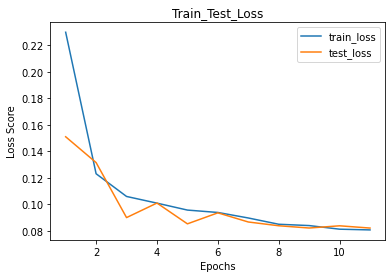

12
Train Epoch: 12 [0/7471 (0%)]	Loss: 0.080096
Train Epoch: 12 [160/7471 (2%)]	Loss: 0.073419
Train Epoch: 12 [320/7471 (4%)]	Loss: 0.077894
Train Epoch: 12 [480/7471 (6%)]	Loss: 0.077551
Train Epoch: 12 [640/7471 (9%)]	Loss: 0.096281
Train Epoch: 12 [800/7471 (11%)]	Loss: 0.071227
Train Epoch: 12 [960/7471 (13%)]	Loss: 0.086441
Train Epoch: 12 [1120/7471 (15%)]	Loss: 0.071544
Train Epoch: 12 [1280/7471 (17%)]	Loss: 0.073462
Train Epoch: 12 [1440/7471 (19%)]	Loss: 0.065752
Train Epoch: 12 [1600/7471 (21%)]	Loss: 0.079671
Train Epoch: 12 [1760/7471 (24%)]	Loss: 0.081826
Train Epoch: 12 [1920/7471 (26%)]	Loss: 0.077119
Train Epoch: 12 [2080/7471 (28%)]	Loss: 0.074550
Train Epoch: 12 [2240/7471 (30%)]	Loss: 0.073418
Train Epoch: 12 [2400/7471 (32%)]	Loss: 0.075198
Train Epoch: 12 [2560/7471 (34%)]	Loss: 0.073011
Train Epoch: 12 [2720/7471 (36%)]	Loss: 0.078778
Train Epoch: 12 [2880/7471 (39%)]	Loss: 0.087389
Train Epoch: 12 [3040/7471 (41%)]	Loss: 0.076068
Train Epoch: 12 [3200/7471 (43%

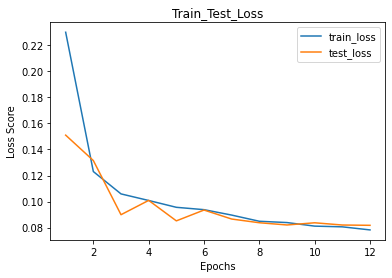

13
Train Epoch: 13 [0/7471 (0%)]	Loss: 0.080039
Train Epoch: 13 [160/7471 (2%)]	Loss: 0.078371
Train Epoch: 13 [320/7471 (4%)]	Loss: 0.077059
Train Epoch: 13 [480/7471 (6%)]	Loss: 0.067609
Train Epoch: 13 [640/7471 (9%)]	Loss: 0.073845
Train Epoch: 13 [800/7471 (11%)]	Loss: 0.071605
Train Epoch: 13 [960/7471 (13%)]	Loss: 0.073563
Train Epoch: 13 [1120/7471 (15%)]	Loss: 0.079101
Train Epoch: 13 [1280/7471 (17%)]	Loss: 0.072955
Train Epoch: 13 [1440/7471 (19%)]	Loss: 0.085548
Train Epoch: 13 [1600/7471 (21%)]	Loss: 0.072319
Train Epoch: 13 [1760/7471 (24%)]	Loss: 0.086281
Train Epoch: 13 [1920/7471 (26%)]	Loss: 0.073861
Train Epoch: 13 [2080/7471 (28%)]	Loss: 0.077973
Train Epoch: 13 [2240/7471 (30%)]	Loss: 0.077393
Train Epoch: 13 [2400/7471 (32%)]	Loss: 0.069748
Train Epoch: 13 [2560/7471 (34%)]	Loss: 0.081860
Train Epoch: 13 [2720/7471 (36%)]	Loss: 0.076891
Train Epoch: 13 [2880/7471 (39%)]	Loss: 0.079986
Train Epoch: 13 [3040/7471 (41%)]	Loss: 0.063970
Train Epoch: 13 [3200/7471 (43%

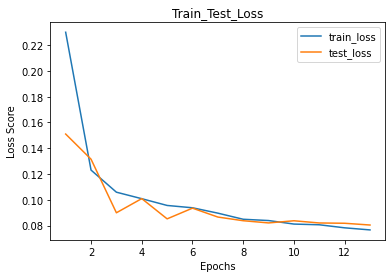

14
Train Epoch: 14 [0/7471 (0%)]	Loss: 0.077704
Train Epoch: 14 [160/7471 (2%)]	Loss: 0.069986
Train Epoch: 14 [320/7471 (4%)]	Loss: 0.068107
Train Epoch: 14 [480/7471 (6%)]	Loss: 0.086431
Train Epoch: 14 [640/7471 (9%)]	Loss: 0.071882
Train Epoch: 14 [800/7471 (11%)]	Loss: 0.079983
Train Epoch: 14 [960/7471 (13%)]	Loss: 0.069982
Train Epoch: 14 [1120/7471 (15%)]	Loss: 0.079420
Train Epoch: 14 [1280/7471 (17%)]	Loss: 0.067357
Train Epoch: 14 [1440/7471 (19%)]	Loss: 0.066512
Train Epoch: 14 [1600/7471 (21%)]	Loss: 0.068617
Train Epoch: 14 [1760/7471 (24%)]	Loss: 0.076765
Train Epoch: 14 [1920/7471 (26%)]	Loss: 0.087701
Train Epoch: 14 [2080/7471 (28%)]	Loss: 0.078354
Train Epoch: 14 [2240/7471 (30%)]	Loss: 0.068898
Train Epoch: 14 [2400/7471 (32%)]	Loss: 0.064510
Train Epoch: 14 [2560/7471 (34%)]	Loss: 0.072981
Train Epoch: 14 [2720/7471 (36%)]	Loss: 0.072316
Train Epoch: 14 [2880/7471 (39%)]	Loss: 0.074400
Train Epoch: 14 [3040/7471 (41%)]	Loss: 0.082041
Train Epoch: 14 [3200/7471 (43%

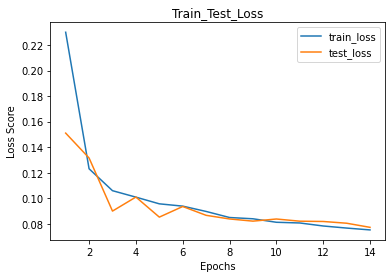

15
Train Epoch: 15 [0/7471 (0%)]	Loss: 0.071293
Train Epoch: 15 [160/7471 (2%)]	Loss: 0.069077
Train Epoch: 15 [320/7471 (4%)]	Loss: 0.077604
Train Epoch: 15 [480/7471 (6%)]	Loss: 0.070868
Train Epoch: 15 [640/7471 (9%)]	Loss: 0.079552
Train Epoch: 15 [800/7471 (11%)]	Loss: 0.068502
Train Epoch: 15 [960/7471 (13%)]	Loss: 0.064498
Train Epoch: 15 [1120/7471 (15%)]	Loss: 0.078338
Train Epoch: 15 [1280/7471 (17%)]	Loss: 0.079005
Train Epoch: 15 [1440/7471 (19%)]	Loss: 0.079391
Train Epoch: 15 [1600/7471 (21%)]	Loss: 0.067141
Train Epoch: 15 [1760/7471 (24%)]	Loss: 0.096283
Train Epoch: 15 [1920/7471 (26%)]	Loss: 0.065054
Train Epoch: 15 [2080/7471 (28%)]	Loss: 0.066421
Train Epoch: 15 [2240/7471 (30%)]	Loss: 0.068646
Train Epoch: 15 [2400/7471 (32%)]	Loss: 0.065694
Train Epoch: 15 [2560/7471 (34%)]	Loss: 0.085581
Train Epoch: 15 [2720/7471 (36%)]	Loss: 0.069943
Train Epoch: 15 [2880/7471 (39%)]	Loss: 0.078790
Train Epoch: 15 [3040/7471 (41%)]	Loss: 0.079941
Train Epoch: 15 [3200/7471 (43%

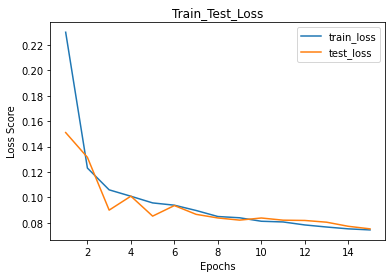

16
Train Epoch: 16 [0/7471 (0%)]	Loss: 0.065652
Train Epoch: 16 [160/7471 (2%)]	Loss: 0.068082
Train Epoch: 16 [320/7471 (4%)]	Loss: 0.064727
Train Epoch: 16 [480/7471 (6%)]	Loss: 0.072821
Train Epoch: 16 [640/7471 (9%)]	Loss: 0.074708
Train Epoch: 16 [800/7471 (11%)]	Loss: 0.066225
Train Epoch: 16 [960/7471 (13%)]	Loss: 0.074593
Train Epoch: 16 [1120/7471 (15%)]	Loss: 0.074542
Train Epoch: 16 [1280/7471 (17%)]	Loss: 0.089673
Train Epoch: 16 [1440/7471 (19%)]	Loss: 0.073024
Train Epoch: 16 [1600/7471 (21%)]	Loss: 0.069789
Train Epoch: 16 [1760/7471 (24%)]	Loss: 0.072287
Train Epoch: 16 [1920/7471 (26%)]	Loss: 0.067096
Train Epoch: 16 [2080/7471 (28%)]	Loss: 0.067989
Train Epoch: 16 [2240/7471 (30%)]	Loss: 0.082542
Train Epoch: 16 [2400/7471 (32%)]	Loss: 0.081173
Train Epoch: 16 [2560/7471 (34%)]	Loss: 0.062753
Train Epoch: 16 [2720/7471 (36%)]	Loss: 0.067104
Train Epoch: 16 [2880/7471 (39%)]	Loss: 0.067941
Train Epoch: 16 [3040/7471 (41%)]	Loss: 0.064288
Train Epoch: 16 [3200/7471 (43%

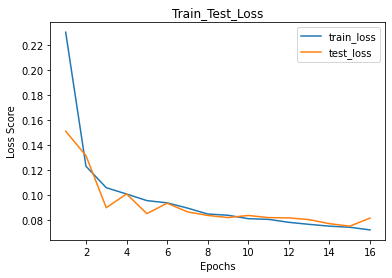

17
Train Epoch: 17 [0/7471 (0%)]	Loss: 0.071913
Train Epoch: 17 [160/7471 (2%)]	Loss: 0.071148
Train Epoch: 17 [320/7471 (4%)]	Loss: 0.073700
Train Epoch: 17 [480/7471 (6%)]	Loss: 0.068984
Train Epoch: 17 [640/7471 (9%)]	Loss: 0.074628
Train Epoch: 17 [800/7471 (11%)]	Loss: 0.073912
Train Epoch: 17 [960/7471 (13%)]	Loss: 0.072679
Train Epoch: 17 [1120/7471 (15%)]	Loss: 0.069635
Train Epoch: 17 [1280/7471 (17%)]	Loss: 0.066675
Train Epoch: 17 [1440/7471 (19%)]	Loss: 0.067454
Train Epoch: 17 [1600/7471 (21%)]	Loss: 0.063647
Train Epoch: 17 [1760/7471 (24%)]	Loss: 0.078125
Train Epoch: 17 [1920/7471 (26%)]	Loss: 0.091253
Train Epoch: 17 [2080/7471 (28%)]	Loss: 0.077422
Train Epoch: 17 [2240/7471 (30%)]	Loss: 0.077286
Train Epoch: 17 [2400/7471 (32%)]	Loss: 0.068476
Train Epoch: 17 [2560/7471 (34%)]	Loss: 0.076195
Train Epoch: 17 [2720/7471 (36%)]	Loss: 0.069941
Train Epoch: 17 [2880/7471 (39%)]	Loss: 0.067939
Train Epoch: 17 [3040/7471 (41%)]	Loss: 0.065890
Train Epoch: 17 [3200/7471 (43%

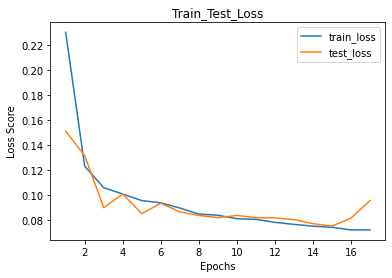

18
Train Epoch: 18 [0/7471 (0%)]	Loss: 0.094531
Train Epoch: 18 [160/7471 (2%)]	Loss: 0.069221
Train Epoch: 18 [320/7471 (4%)]	Loss: 0.070589
Train Epoch: 18 [480/7471 (6%)]	Loss: 0.063293
Train Epoch: 18 [640/7471 (9%)]	Loss: 0.070982
Train Epoch: 18 [800/7471 (11%)]	Loss: 0.068025
Train Epoch: 18 [960/7471 (13%)]	Loss: 0.075755
Train Epoch: 18 [1120/7471 (15%)]	Loss: 0.081133
Train Epoch: 18 [1280/7471 (17%)]	Loss: 0.071974
Train Epoch: 18 [1440/7471 (19%)]	Loss: 0.077392
Train Epoch: 18 [1600/7471 (21%)]	Loss: 0.068190
Train Epoch: 18 [1760/7471 (24%)]	Loss: 0.071647
Train Epoch: 18 [1920/7471 (26%)]	Loss: 0.066870
Train Epoch: 18 [2080/7471 (28%)]	Loss: 0.062569
Train Epoch: 18 [2240/7471 (30%)]	Loss: 0.066113
Train Epoch: 18 [2400/7471 (32%)]	Loss: 0.065093
Train Epoch: 18 [2560/7471 (34%)]	Loss: 0.072958
Train Epoch: 18 [2720/7471 (36%)]	Loss: 0.065371
Train Epoch: 18 [2880/7471 (39%)]	Loss: 0.064869
Train Epoch: 18 [3040/7471 (41%)]	Loss: 0.066352
Train Epoch: 18 [3200/7471 (43%

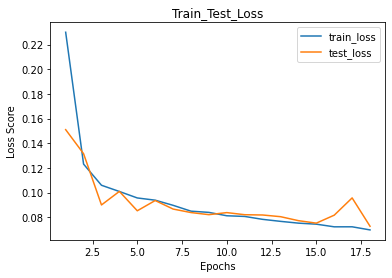

19
Train Epoch: 19 [0/7471 (0%)]	Loss: 0.064573
Train Epoch: 19 [160/7471 (2%)]	Loss: 0.065016
Train Epoch: 19 [320/7471 (4%)]	Loss: 0.079827
Train Epoch: 19 [480/7471 (6%)]	Loss: 0.062042
Train Epoch: 19 [640/7471 (9%)]	Loss: 0.065354
Train Epoch: 19 [800/7471 (11%)]	Loss: 0.064598
Train Epoch: 19 [960/7471 (13%)]	Loss: 0.066794
Train Epoch: 19 [1120/7471 (15%)]	Loss: 0.067244
Train Epoch: 19 [1280/7471 (17%)]	Loss: 0.065332
Train Epoch: 19 [1440/7471 (19%)]	Loss: 0.066017
Train Epoch: 19 [1600/7471 (21%)]	Loss: 0.070576
Train Epoch: 19 [1760/7471 (24%)]	Loss: 0.066828
Train Epoch: 19 [1920/7471 (26%)]	Loss: 0.078609
Train Epoch: 19 [2080/7471 (28%)]	Loss: 0.065837
Train Epoch: 19 [2240/7471 (30%)]	Loss: 0.073627
Train Epoch: 19 [2400/7471 (32%)]	Loss: 0.067838
Train Epoch: 19 [2560/7471 (34%)]	Loss: 0.074311
Train Epoch: 19 [2720/7471 (36%)]	Loss: 0.097644
Train Epoch: 19 [2880/7471 (39%)]	Loss: 0.075828
Train Epoch: 19 [3040/7471 (41%)]	Loss: 0.080890
Train Epoch: 19 [3200/7471 (43%

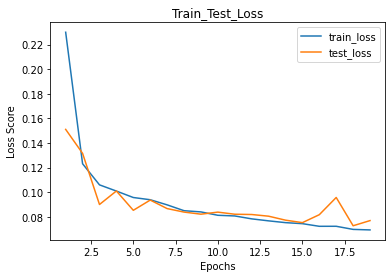

20
Train Epoch: 20 [0/7471 (0%)]	Loss: 0.069086
Train Epoch: 20 [160/7471 (2%)]	Loss: 0.066040
Train Epoch: 20 [320/7471 (4%)]	Loss: 0.068795
Train Epoch: 20 [480/7471 (6%)]	Loss: 0.069191
Train Epoch: 20 [640/7471 (9%)]	Loss: 0.066841
Train Epoch: 20 [800/7471 (11%)]	Loss: 0.072056
Train Epoch: 20 [960/7471 (13%)]	Loss: 0.064960
Train Epoch: 20 [1120/7471 (15%)]	Loss: 0.069948
Train Epoch: 20 [1280/7471 (17%)]	Loss: 0.059679
Train Epoch: 20 [1440/7471 (19%)]	Loss: 0.065403
Train Epoch: 20 [1600/7471 (21%)]	Loss: 0.089209
Train Epoch: 20 [1760/7471 (24%)]	Loss: 0.067740
Train Epoch: 20 [1920/7471 (26%)]	Loss: 0.061486
Train Epoch: 20 [2080/7471 (28%)]	Loss: 0.066289
Train Epoch: 20 [2240/7471 (30%)]	Loss: 0.079480
Train Epoch: 20 [2400/7471 (32%)]	Loss: 0.068403
Train Epoch: 20 [2560/7471 (34%)]	Loss: 0.075874
Train Epoch: 20 [2720/7471 (36%)]	Loss: 0.062972
Train Epoch: 20 [2880/7471 (39%)]	Loss: 0.060517
Train Epoch: 20 [3040/7471 (41%)]	Loss: 0.062876
Train Epoch: 20 [3200/7471 (43%

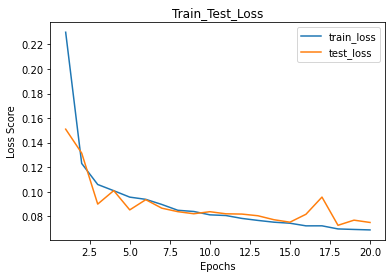

21
Train Epoch: 21 [0/7471 (0%)]	Loss: 0.065093
Train Epoch: 21 [160/7471 (2%)]	Loss: 0.061931
Train Epoch: 21 [320/7471 (4%)]	Loss: 0.064802
Train Epoch: 21 [480/7471 (6%)]	Loss: 0.061691
Train Epoch: 21 [640/7471 (9%)]	Loss: 0.071152
Train Epoch: 21 [800/7471 (11%)]	Loss: 0.069168
Train Epoch: 21 [960/7471 (13%)]	Loss: 0.068753
Train Epoch: 21 [1120/7471 (15%)]	Loss: 0.086650
Train Epoch: 21 [1280/7471 (17%)]	Loss: 0.063258
Train Epoch: 21 [1440/7471 (19%)]	Loss: 0.063683
Train Epoch: 21 [1600/7471 (21%)]	Loss: 0.067492
Train Epoch: 21 [1760/7471 (24%)]	Loss: 0.063802
Train Epoch: 21 [1920/7471 (26%)]	Loss: 0.072733
Train Epoch: 21 [2080/7471 (28%)]	Loss: 0.072949
Train Epoch: 21 [2240/7471 (30%)]	Loss: 0.085581
Train Epoch: 21 [2400/7471 (32%)]	Loss: 0.066456
Train Epoch: 21 [2560/7471 (34%)]	Loss: 0.063438
Train Epoch: 21 [2720/7471 (36%)]	Loss: 0.072203
Train Epoch: 21 [2880/7471 (39%)]	Loss: 0.071590
Train Epoch: 21 [3040/7471 (41%)]	Loss: 0.061221
Train Epoch: 21 [3200/7471 (43%

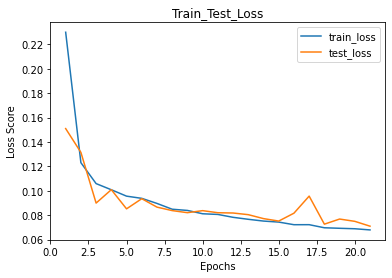

22
Train Epoch: 22 [0/7471 (0%)]	Loss: 0.063463
Train Epoch: 22 [160/7471 (2%)]	Loss: 0.067596
Train Epoch: 22 [320/7471 (4%)]	Loss: 0.061172
Train Epoch: 22 [480/7471 (6%)]	Loss: 0.060209
Train Epoch: 22 [640/7471 (9%)]	Loss: 0.057952
Train Epoch: 22 [800/7471 (11%)]	Loss: 0.059735
Train Epoch: 22 [960/7471 (13%)]	Loss: 0.072712
Train Epoch: 22 [1120/7471 (15%)]	Loss: 0.069322
Train Epoch: 22 [1280/7471 (17%)]	Loss: 0.062584
Train Epoch: 22 [1440/7471 (19%)]	Loss: 0.073478
Train Epoch: 22 [1600/7471 (21%)]	Loss: 0.060972
Train Epoch: 22 [1760/7471 (24%)]	Loss: 0.065588
Train Epoch: 22 [1920/7471 (26%)]	Loss: 0.074089
Train Epoch: 22 [2080/7471 (28%)]	Loss: 0.067171
Train Epoch: 22 [2240/7471 (30%)]	Loss: 0.065968
Train Epoch: 22 [2400/7471 (32%)]	Loss: 0.068311
Train Epoch: 22 [2560/7471 (34%)]	Loss: 0.069831
Train Epoch: 22 [2720/7471 (36%)]	Loss: 0.062221
Train Epoch: 22 [2880/7471 (39%)]	Loss: 0.073826
Train Epoch: 22 [3040/7471 (41%)]	Loss: 0.072970
Train Epoch: 22 [3200/7471 (43%

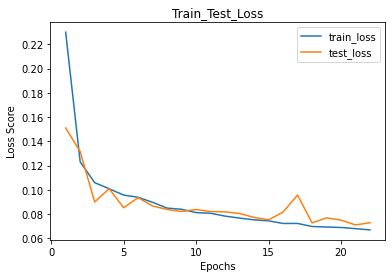

23
Train Epoch: 23 [0/7471 (0%)]	Loss: 0.065734
Train Epoch: 23 [160/7471 (2%)]	Loss: 0.060056
Train Epoch: 23 [320/7471 (4%)]	Loss: 0.063338
Train Epoch: 23 [480/7471 (6%)]	Loss: 0.064529
Train Epoch: 23 [640/7471 (9%)]	Loss: 0.063478
Train Epoch: 23 [800/7471 (11%)]	Loss: 0.065689
Train Epoch: 23 [960/7471 (13%)]	Loss: 0.061818
Train Epoch: 23 [1120/7471 (15%)]	Loss: 0.064710
Train Epoch: 23 [1280/7471 (17%)]	Loss: 0.067715
Train Epoch: 23 [1440/7471 (19%)]	Loss: 0.072605
Train Epoch: 23 [1600/7471 (21%)]	Loss: 0.068887
Train Epoch: 23 [1760/7471 (24%)]	Loss: 0.068025
Train Epoch: 23 [1920/7471 (26%)]	Loss: 0.066443
Train Epoch: 23 [2080/7471 (28%)]	Loss: 0.072270
Train Epoch: 23 [2240/7471 (30%)]	Loss: 0.058568
Train Epoch: 23 [2400/7471 (32%)]	Loss: 0.067432
Train Epoch: 23 [2560/7471 (34%)]	Loss: 0.066248
Train Epoch: 23 [2720/7471 (36%)]	Loss: 0.079746
Train Epoch: 23 [2880/7471 (39%)]	Loss: 0.063415
Train Epoch: 23 [3040/7471 (41%)]	Loss: 0.063178
Train Epoch: 23 [3200/7471 (43%

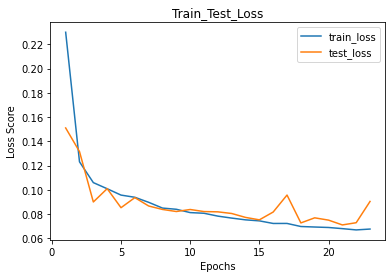

24
Train Epoch: 24 [0/7471 (0%)]	Loss: 0.079460
Train Epoch: 24 [160/7471 (2%)]	Loss: 0.060070
Train Epoch: 24 [320/7471 (4%)]	Loss: 0.062832
Train Epoch: 24 [480/7471 (6%)]	Loss: 0.069817
Train Epoch: 24 [640/7471 (9%)]	Loss: 0.064355
Train Epoch: 24 [800/7471 (11%)]	Loss: 0.062022
Train Epoch: 24 [960/7471 (13%)]	Loss: 0.067806
Train Epoch: 24 [1120/7471 (15%)]	Loss: 0.060003
Train Epoch: 24 [1280/7471 (17%)]	Loss: 0.062035
Train Epoch: 24 [1440/7471 (19%)]	Loss: 0.063798
Train Epoch: 24 [1600/7471 (21%)]	Loss: 0.062807
Train Epoch: 24 [1760/7471 (24%)]	Loss: 0.061203
Train Epoch: 24 [1920/7471 (26%)]	Loss: 0.068973
Train Epoch: 24 [2080/7471 (28%)]	Loss: 0.082903
Train Epoch: 24 [2240/7471 (30%)]	Loss: 0.064008
Train Epoch: 24 [2400/7471 (32%)]	Loss: 0.065034
Train Epoch: 24 [2560/7471 (34%)]	Loss: 0.067078
Train Epoch: 24 [2720/7471 (36%)]	Loss: 0.072426
Train Epoch: 24 [2880/7471 (39%)]	Loss: 0.061107
Train Epoch: 24 [3040/7471 (41%)]	Loss: 0.065489
Train Epoch: 24 [3200/7471 (43%

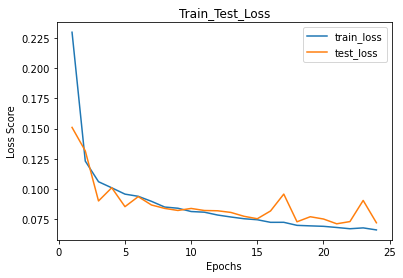

25
Train Epoch: 25 [0/7471 (0%)]	Loss: 0.060450
Train Epoch: 25 [160/7471 (2%)]	Loss: 0.060099
Train Epoch: 25 [320/7471 (4%)]	Loss: 0.065712
Train Epoch: 25 [480/7471 (6%)]	Loss: 0.067389
Train Epoch: 25 [640/7471 (9%)]	Loss: 0.063849
Train Epoch: 25 [800/7471 (11%)]	Loss: 0.061289
Train Epoch: 25 [960/7471 (13%)]	Loss: 0.062098
Train Epoch: 25 [1120/7471 (15%)]	Loss: 0.061160
Train Epoch: 25 [1280/7471 (17%)]	Loss: 0.062445
Train Epoch: 25 [1440/7471 (19%)]	Loss: 0.061326
Train Epoch: 25 [1600/7471 (21%)]	Loss: 0.065754
Train Epoch: 25 [1760/7471 (24%)]	Loss: 0.063615
Train Epoch: 25 [1920/7471 (26%)]	Loss: 0.060371
Train Epoch: 25 [2080/7471 (28%)]	Loss: 0.068836
Train Epoch: 25 [2240/7471 (30%)]	Loss: 0.074990
Train Epoch: 25 [2400/7471 (32%)]	Loss: 0.070504
Train Epoch: 25 [2560/7471 (34%)]	Loss: 0.076034
Train Epoch: 25 [2720/7471 (36%)]	Loss: 0.088027
Train Epoch: 25 [2880/7471 (39%)]	Loss: 0.081387
Train Epoch: 25 [3040/7471 (41%)]	Loss: 0.056825
Train Epoch: 25 [3200/7471 (43%

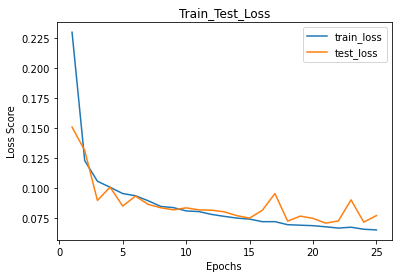

26
Train Epoch: 26 [0/7471 (0%)]	Loss: 0.066911
Train Epoch: 26 [160/7471 (2%)]	Loss: 0.067738
Train Epoch: 26 [320/7471 (4%)]	Loss: 0.061933
Train Epoch: 26 [480/7471 (6%)]	Loss: 0.072596
Train Epoch: 26 [640/7471 (9%)]	Loss: 0.059006
Train Epoch: 26 [800/7471 (11%)]	Loss: 0.063175
Train Epoch: 26 [960/7471 (13%)]	Loss: 0.060843
Train Epoch: 26 [1120/7471 (15%)]	Loss: 0.062401
Train Epoch: 26 [1280/7471 (17%)]	Loss: 0.060778
Train Epoch: 26 [1440/7471 (19%)]	Loss: 0.062942
Train Epoch: 26 [1600/7471 (21%)]	Loss: 0.059458
Train Epoch: 26 [1760/7471 (24%)]	Loss: 0.059251
Train Epoch: 26 [1920/7471 (26%)]	Loss: 0.060578
Train Epoch: 26 [2080/7471 (28%)]	Loss: 0.059388
Train Epoch: 26 [2240/7471 (30%)]	Loss: 0.057296
Train Epoch: 26 [2400/7471 (32%)]	Loss: 0.057539
Train Epoch: 26 [2560/7471 (34%)]	Loss: 0.058293
Train Epoch: 26 [2720/7471 (36%)]	Loss: 0.059225
Train Epoch: 26 [2880/7471 (39%)]	Loss: 0.062452
Train Epoch: 26 [3040/7471 (41%)]	Loss: 0.061879
Train Epoch: 26 [3200/7471 (43%

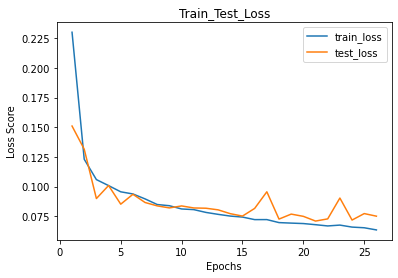

27
Train Epoch: 27 [0/7471 (0%)]	Loss: 0.067350
Train Epoch: 27 [160/7471 (2%)]	Loss: 0.060858
Train Epoch: 27 [320/7471 (4%)]	Loss: 0.063793
Train Epoch: 27 [480/7471 (6%)]	Loss: 0.078278
Train Epoch: 27 [640/7471 (9%)]	Loss: 0.073958
Train Epoch: 27 [800/7471 (11%)]	Loss: 0.061226
Train Epoch: 27 [960/7471 (13%)]	Loss: 0.065120
Train Epoch: 27 [1120/7471 (15%)]	Loss: 0.065515
Train Epoch: 27 [1280/7471 (17%)]	Loss: 0.060421
Train Epoch: 27 [1440/7471 (19%)]	Loss: 0.062448
Train Epoch: 27 [1600/7471 (21%)]	Loss: 0.068139
Train Epoch: 27 [1760/7471 (24%)]	Loss: 0.066641
Train Epoch: 27 [1920/7471 (26%)]	Loss: 0.062658
Train Epoch: 27 [2080/7471 (28%)]	Loss: 0.065616
Train Epoch: 27 [2240/7471 (30%)]	Loss: 0.063904
Train Epoch: 27 [2400/7471 (32%)]	Loss: 0.063026
Train Epoch: 27 [2560/7471 (34%)]	Loss: 0.065657
Train Epoch: 27 [2720/7471 (36%)]	Loss: 0.061230
Train Epoch: 27 [2880/7471 (39%)]	Loss: 0.059082
Train Epoch: 27 [3040/7471 (41%)]	Loss: 0.064368
Train Epoch: 27 [3200/7471 (43%

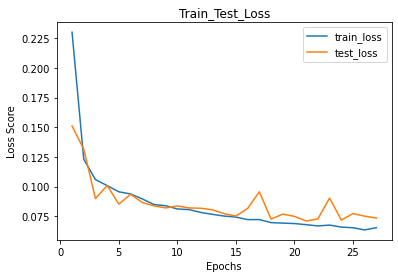

28
Train Epoch: 28 [0/7471 (0%)]	Loss: 0.060697
Train Epoch: 28 [160/7471 (2%)]	Loss: 0.060619
Train Epoch: 28 [320/7471 (4%)]	Loss: 0.062564
Train Epoch: 28 [480/7471 (6%)]	Loss: 0.063084
Train Epoch: 28 [640/7471 (9%)]	Loss: 0.062360
Train Epoch: 28 [800/7471 (11%)]	Loss: 0.066086
Train Epoch: 28 [960/7471 (13%)]	Loss: 0.064580
Train Epoch: 28 [1120/7471 (15%)]	Loss: 0.063658
Train Epoch: 28 [1280/7471 (17%)]	Loss: 0.059421
Train Epoch: 28 [1440/7471 (19%)]	Loss: 0.062555
Train Epoch: 28 [1600/7471 (21%)]	Loss: 0.061901
Train Epoch: 28 [1760/7471 (24%)]	Loss: 0.059527
Train Epoch: 28 [1920/7471 (26%)]	Loss: 0.057961
Train Epoch: 28 [2080/7471 (28%)]	Loss: 0.059716
Train Epoch: 28 [2240/7471 (30%)]	Loss: 0.060957
Train Epoch: 28 [2400/7471 (32%)]	Loss: 0.056184
Train Epoch: 28 [2560/7471 (34%)]	Loss: 0.059160
Train Epoch: 28 [2720/7471 (36%)]	Loss: 0.059313
Train Epoch: 28 [2880/7471 (39%)]	Loss: 0.060827
Train Epoch: 28 [3040/7471 (41%)]	Loss: 0.056362
Train Epoch: 28 [3200/7471 (43%

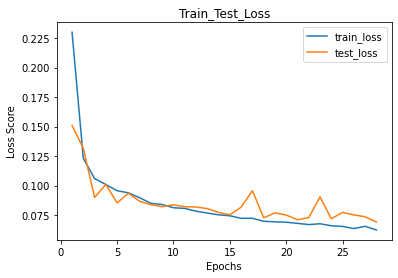

29
Train Epoch: 29 [0/7471 (0%)]	Loss: 0.054767
Train Epoch: 29 [160/7471 (2%)]	Loss: 0.064049
Train Epoch: 29 [320/7471 (4%)]	Loss: 0.061751
Train Epoch: 29 [480/7471 (6%)]	Loss: 0.060774
Train Epoch: 29 [640/7471 (9%)]	Loss: 0.062577
Train Epoch: 29 [800/7471 (11%)]	Loss: 0.059849
Train Epoch: 29 [960/7471 (13%)]	Loss: 0.058108
Train Epoch: 29 [1120/7471 (15%)]	Loss: 0.057945
Train Epoch: 29 [1280/7471 (17%)]	Loss: 0.059404
Train Epoch: 29 [1440/7471 (19%)]	Loss: 0.058014
Train Epoch: 29 [1600/7471 (21%)]	Loss: 0.065659
Train Epoch: 29 [1760/7471 (24%)]	Loss: 0.065974
Train Epoch: 29 [1920/7471 (26%)]	Loss: 0.064361
Train Epoch: 29 [2080/7471 (28%)]	Loss: 0.059349
Train Epoch: 29 [2240/7471 (30%)]	Loss: 0.072429
Train Epoch: 29 [2400/7471 (32%)]	Loss: 0.057719
Train Epoch: 29 [2560/7471 (34%)]	Loss: 0.059763
Train Epoch: 29 [2720/7471 (36%)]	Loss: 0.062079
Train Epoch: 29 [2880/7471 (39%)]	Loss: 0.063157
Train Epoch: 29 [3040/7471 (41%)]	Loss: 0.061834
Train Epoch: 29 [3200/7471 (43%

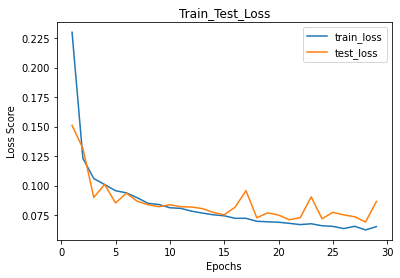

30
Train Epoch: 30 [0/7471 (0%)]	Loss: 0.071219
Train Epoch: 30 [160/7471 (2%)]	Loss: 0.065461
Train Epoch: 30 [320/7471 (4%)]	Loss: 0.095567
Train Epoch: 30 [480/7471 (6%)]	Loss: 0.068996
Train Epoch: 30 [640/7471 (9%)]	Loss: 0.059394
Train Epoch: 30 [800/7471 (11%)]	Loss: 0.059872
Train Epoch: 30 [960/7471 (13%)]	Loss: 0.057946
Train Epoch: 30 [1120/7471 (15%)]	Loss: 0.054884
Train Epoch: 30 [1280/7471 (17%)]	Loss: 0.057494
Train Epoch: 30 [1440/7471 (19%)]	Loss: 0.055489
Train Epoch: 30 [1600/7471 (21%)]	Loss: 0.069978
Train Epoch: 30 [1760/7471 (24%)]	Loss: 0.068851
Train Epoch: 30 [1920/7471 (26%)]	Loss: 0.060401
Train Epoch: 30 [2080/7471 (28%)]	Loss: 0.059862
Train Epoch: 30 [2240/7471 (30%)]	Loss: 0.062165
Train Epoch: 30 [2400/7471 (32%)]	Loss: 0.056453
Train Epoch: 30 [2560/7471 (34%)]	Loss: 0.055413
Train Epoch: 30 [2720/7471 (36%)]	Loss: 0.057064
Train Epoch: 30 [2880/7471 (39%)]	Loss: 0.061827
Train Epoch: 30 [3040/7471 (41%)]	Loss: 0.057187
Train Epoch: 30 [3200/7471 (43%

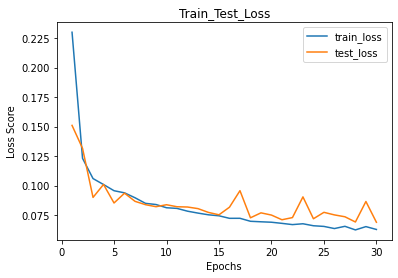

31
Train Epoch: 31 [0/7471 (0%)]	Loss: 0.058676
Train Epoch: 31 [160/7471 (2%)]	Loss: 0.055606
Train Epoch: 31 [320/7471 (4%)]	Loss: 0.056509
Train Epoch: 31 [480/7471 (6%)]	Loss: 0.058421
Train Epoch: 31 [640/7471 (9%)]	Loss: 0.058101
Train Epoch: 31 [800/7471 (11%)]	Loss: 0.057485
Train Epoch: 31 [960/7471 (13%)]	Loss: 0.056737
Train Epoch: 31 [1120/7471 (15%)]	Loss: 0.058180
Train Epoch: 31 [1280/7471 (17%)]	Loss: 0.060575
Train Epoch: 31 [1440/7471 (19%)]	Loss: 0.061769
Train Epoch: 31 [1600/7471 (21%)]	Loss: 0.056820
Train Epoch: 31 [1760/7471 (24%)]	Loss: 0.057145
Train Epoch: 31 [1920/7471 (26%)]	Loss: 0.064776
Train Epoch: 31 [2080/7471 (28%)]	Loss: 0.063786
Train Epoch: 31 [2240/7471 (30%)]	Loss: 0.062365
Train Epoch: 31 [2400/7471 (32%)]	Loss: 0.060030
Train Epoch: 31 [2560/7471 (34%)]	Loss: 0.065622
Train Epoch: 31 [2720/7471 (36%)]	Loss: 0.062758
Train Epoch: 31 [2880/7471 (39%)]	Loss: 0.062500
Train Epoch: 31 [3040/7471 (41%)]	Loss: 0.058909
Train Epoch: 31 [3200/7471 (43%

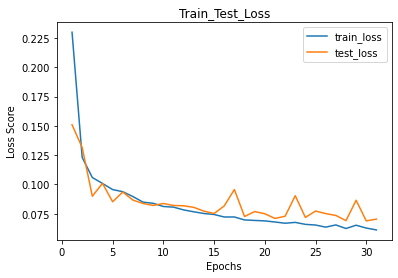

32
Train Epoch: 32 [0/7471 (0%)]	Loss: 0.064196
Train Epoch: 32 [160/7471 (2%)]	Loss: 0.061035
Train Epoch: 32 [320/7471 (4%)]	Loss: 0.065656
Train Epoch: 32 [480/7471 (6%)]	Loss: 0.060665
Train Epoch: 32 [640/7471 (9%)]	Loss: 0.058186
Train Epoch: 32 [800/7471 (11%)]	Loss: 0.058606
Train Epoch: 32 [960/7471 (13%)]	Loss: 0.056901
Train Epoch: 32 [1120/7471 (15%)]	Loss: 0.054366
Train Epoch: 32 [1280/7471 (17%)]	Loss: 0.059107
Train Epoch: 32 [1440/7471 (19%)]	Loss: 0.054595
Train Epoch: 32 [1600/7471 (21%)]	Loss: 0.066157
Train Epoch: 32 [1760/7471 (24%)]	Loss: 0.058134
Train Epoch: 32 [1920/7471 (26%)]	Loss: 0.067449
Train Epoch: 32 [2080/7471 (28%)]	Loss: 0.055789
Train Epoch: 32 [2240/7471 (30%)]	Loss: 0.054218
Train Epoch: 32 [2400/7471 (32%)]	Loss: 0.056781
Train Epoch: 32 [2560/7471 (34%)]	Loss: 0.070643
Train Epoch: 32 [2720/7471 (36%)]	Loss: 0.061974
Train Epoch: 32 [2880/7471 (39%)]	Loss: 0.070176
Train Epoch: 32 [3040/7471 (41%)]	Loss: 0.063802
Train Epoch: 32 [3200/7471 (43%

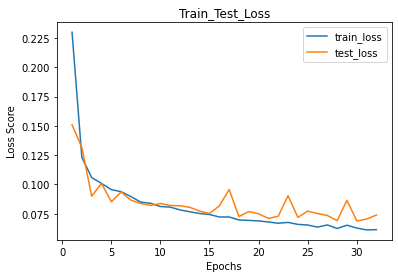

33
Train Epoch: 33 [0/7471 (0%)]	Loss: 0.062153
Train Epoch: 33 [160/7471 (2%)]	Loss: 0.060885
Train Epoch: 33 [320/7471 (4%)]	Loss: 0.071780
Train Epoch: 33 [480/7471 (6%)]	Loss: 0.064947
Train Epoch: 33 [640/7471 (9%)]	Loss: 0.061890
Train Epoch: 33 [800/7471 (11%)]	Loss: 0.057677
Train Epoch: 33 [960/7471 (13%)]	Loss: 0.056489
Train Epoch: 33 [1120/7471 (15%)]	Loss: 0.057386
Train Epoch: 33 [1280/7471 (17%)]	Loss: 0.054782
Train Epoch: 33 [1440/7471 (19%)]	Loss: 0.056020
Train Epoch: 33 [1600/7471 (21%)]	Loss: 0.056056
Train Epoch: 33 [1760/7471 (24%)]	Loss: 0.059072
Train Epoch: 33 [1920/7471 (26%)]	Loss: 0.056975
Train Epoch: 33 [2080/7471 (28%)]	Loss: 0.056669
Train Epoch: 33 [2240/7471 (30%)]	Loss: 0.055789
Train Epoch: 33 [2400/7471 (32%)]	Loss: 0.059929
Train Epoch: 33 [2560/7471 (34%)]	Loss: 0.059296
Train Epoch: 33 [2720/7471 (36%)]	Loss: 0.058511
Train Epoch: 33 [2880/7471 (39%)]	Loss: 0.058901
Train Epoch: 33 [3040/7471 (41%)]	Loss: 0.057581
Train Epoch: 33 [3200/7471 (43%

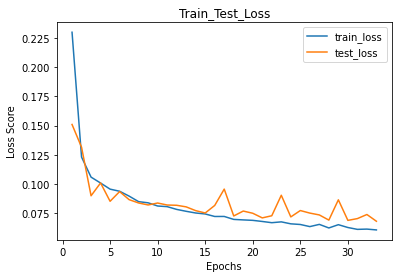

34
Train Epoch: 34 [0/7471 (0%)]	Loss: 0.055397
Train Epoch: 34 [160/7471 (2%)]	Loss: 0.054896
Train Epoch: 34 [320/7471 (4%)]	Loss: 0.076274
Train Epoch: 34 [480/7471 (6%)]	Loss: 0.057914
Train Epoch: 34 [640/7471 (9%)]	Loss: 0.056813
Train Epoch: 34 [800/7471 (11%)]	Loss: 0.060894
Train Epoch: 34 [960/7471 (13%)]	Loss: 0.059125
Train Epoch: 34 [1120/7471 (15%)]	Loss: 0.126867
Train Epoch: 34 [1280/7471 (17%)]	Loss: 0.060815
Train Epoch: 34 [1440/7471 (19%)]	Loss: 0.056553
Train Epoch: 34 [1600/7471 (21%)]	Loss: 0.069743
Train Epoch: 34 [1760/7471 (24%)]	Loss: 0.064161
Train Epoch: 34 [1920/7471 (26%)]	Loss: 0.062782
Train Epoch: 34 [2080/7471 (28%)]	Loss: 0.052514
Train Epoch: 34 [2240/7471 (30%)]	Loss: 0.055762
Train Epoch: 34 [2400/7471 (32%)]	Loss: 0.057609
Train Epoch: 34 [2560/7471 (34%)]	Loss: 0.057764
Train Epoch: 34 [2720/7471 (36%)]	Loss: 0.060002
Train Epoch: 34 [2880/7471 (39%)]	Loss: 0.063942
Train Epoch: 34 [3040/7471 (41%)]	Loss: 0.059672
Train Epoch: 34 [3200/7471 (43%

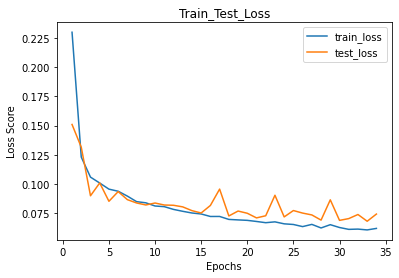

35
Train Epoch: 35 [0/7471 (0%)]	Loss: 0.062453
Train Epoch: 35 [160/7471 (2%)]	Loss: 0.059193
Train Epoch: 35 [320/7471 (4%)]	Loss: 0.060597
Train Epoch: 35 [480/7471 (6%)]	Loss: 0.057617
Train Epoch: 35 [640/7471 (9%)]	Loss: 0.059300
Train Epoch: 35 [800/7471 (11%)]	Loss: 0.059422
Train Epoch: 35 [960/7471 (13%)]	Loss: 0.061963
Train Epoch: 35 [1120/7471 (15%)]	Loss: 0.087781
Train Epoch: 35 [1280/7471 (17%)]	Loss: 0.084347
Train Epoch: 35 [1440/7471 (19%)]	Loss: 0.091185
Train Epoch: 35 [1600/7471 (21%)]	Loss: 0.071812
Train Epoch: 35 [1760/7471 (24%)]	Loss: 0.094679
Train Epoch: 35 [1920/7471 (26%)]	Loss: 0.062766
Train Epoch: 35 [2080/7471 (28%)]	Loss: 0.062511
Train Epoch: 35 [2240/7471 (30%)]	Loss: 0.058507
Train Epoch: 35 [2400/7471 (32%)]	Loss: 0.059205
Train Epoch: 35 [2560/7471 (34%)]	Loss: 0.057825
Train Epoch: 35 [2720/7471 (36%)]	Loss: 0.054381
Train Epoch: 35 [2880/7471 (39%)]	Loss: 0.061222
Train Epoch: 35 [3040/7471 (41%)]	Loss: 0.060248
Train Epoch: 35 [3200/7471 (43%

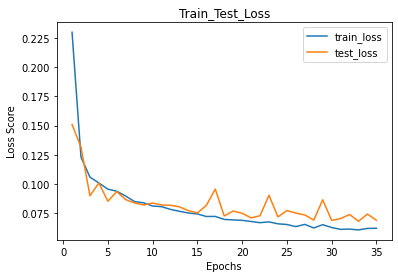

36
Train Epoch: 36 [0/7471 (0%)]	Loss: 0.055369
Train Epoch: 36 [160/7471 (2%)]	Loss: 0.061535
Train Epoch: 36 [320/7471 (4%)]	Loss: 0.061627
Train Epoch: 36 [480/7471 (6%)]	Loss: 0.054812
Train Epoch: 36 [640/7471 (9%)]	Loss: 0.054654
Train Epoch: 36 [800/7471 (11%)]	Loss: 0.055737
Train Epoch: 36 [960/7471 (13%)]	Loss: 0.061812
Train Epoch: 36 [1120/7471 (15%)]	Loss: 0.056595
Train Epoch: 36 [1280/7471 (17%)]	Loss: 0.055684
Train Epoch: 36 [1440/7471 (19%)]	Loss: 0.058559
Train Epoch: 36 [1600/7471 (21%)]	Loss: 0.058377
Train Epoch: 36 [1760/7471 (24%)]	Loss: 0.058047
Train Epoch: 36 [1920/7471 (26%)]	Loss: 0.054694
Train Epoch: 36 [2080/7471 (28%)]	Loss: 0.057816
Train Epoch: 36 [2240/7471 (30%)]	Loss: 0.059917
Train Epoch: 36 [2400/7471 (32%)]	Loss: 0.062079
Train Epoch: 36 [2560/7471 (34%)]	Loss: 0.054882
Train Epoch: 36 [2720/7471 (36%)]	Loss: 0.056920
Train Epoch: 36 [2880/7471 (39%)]	Loss: 0.061928
Train Epoch: 36 [3040/7471 (41%)]	Loss: 0.058380
Train Epoch: 36 [3200/7471 (43%

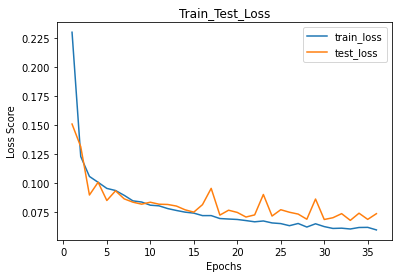

37
Train Epoch: 37 [0/7471 (0%)]	Loss: 0.061307
Train Epoch: 37 [160/7471 (2%)]	Loss: 0.057923
Train Epoch: 37 [320/7471 (4%)]	Loss: 0.058927
Train Epoch: 37 [480/7471 (6%)]	Loss: 0.054541
Train Epoch: 37 [640/7471 (9%)]	Loss: 0.056193
Train Epoch: 37 [800/7471 (11%)]	Loss: 0.053325
Train Epoch: 37 [960/7471 (13%)]	Loss: 0.063302
Train Epoch: 37 [1120/7471 (15%)]	Loss: 0.057479
Train Epoch: 37 [1280/7471 (17%)]	Loss: 0.056719
Train Epoch: 37 [1440/7471 (19%)]	Loss: 0.057936
Train Epoch: 37 [1600/7471 (21%)]	Loss: 0.056463
Train Epoch: 37 [1760/7471 (24%)]	Loss: 0.054341
Train Epoch: 37 [1920/7471 (26%)]	Loss: 0.059846
Train Epoch: 37 [2080/7471 (28%)]	Loss: 0.061557
Train Epoch: 37 [2240/7471 (30%)]	Loss: 0.064967
Train Epoch: 37 [2400/7471 (32%)]	Loss: 0.056919
Train Epoch: 37 [2560/7471 (34%)]	Loss: 0.064023
Train Epoch: 37 [2720/7471 (36%)]	Loss: 0.061112
Train Epoch: 37 [2880/7471 (39%)]	Loss: 0.054338
Train Epoch: 37 [3040/7471 (41%)]	Loss: 0.074201
Train Epoch: 37 [3200/7471 (43%

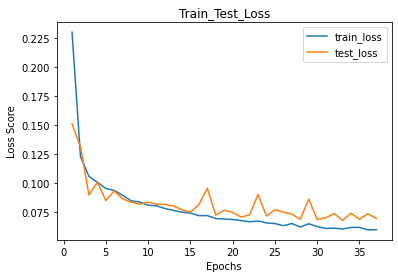

38
Train Epoch: 38 [0/7471 (0%)]	Loss: 0.058036
Train Epoch: 38 [160/7471 (2%)]	Loss: 0.069013
Train Epoch: 38 [320/7471 (4%)]	Loss: 0.061622
Train Epoch: 38 [480/7471 (6%)]	Loss: 0.068056
Train Epoch: 38 [640/7471 (9%)]	Loss: 0.060507
Train Epoch: 38 [800/7471 (11%)]	Loss: 0.063133
Train Epoch: 38 [960/7471 (13%)]	Loss: 0.057813
Train Epoch: 38 [1120/7471 (15%)]	Loss: 0.059094
Train Epoch: 38 [1280/7471 (17%)]	Loss: 0.063227
Train Epoch: 38 [1440/7471 (19%)]	Loss: 0.058434
Train Epoch: 38 [1600/7471 (21%)]	Loss: 0.056042
Train Epoch: 38 [1760/7471 (24%)]	Loss: 0.056462
Train Epoch: 38 [1920/7471 (26%)]	Loss: 0.062038
Train Epoch: 38 [2080/7471 (28%)]	Loss: 0.056575
Train Epoch: 38 [2240/7471 (30%)]	Loss: 0.062133
Train Epoch: 38 [2400/7471 (32%)]	Loss: 0.055297
Train Epoch: 38 [2560/7471 (34%)]	Loss: 0.054038
Train Epoch: 38 [2720/7471 (36%)]	Loss: 0.056687
Train Epoch: 38 [2880/7471 (39%)]	Loss: 0.068460
Train Epoch: 38 [3040/7471 (41%)]	Loss: 0.056837
Train Epoch: 38 [3200/7471 (43%

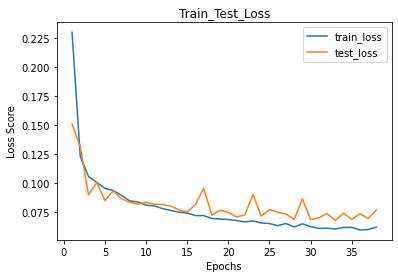

39
Train Epoch: 39 [0/7471 (0%)]	Loss: 0.063924
Train Epoch: 39 [160/7471 (2%)]	Loss: 0.068855
Train Epoch: 39 [320/7471 (4%)]	Loss: 0.069783
Train Epoch: 39 [480/7471 (6%)]	Loss: 0.064996
Train Epoch: 39 [640/7471 (9%)]	Loss: 0.065562
Train Epoch: 39 [800/7471 (11%)]	Loss: 0.055476
Train Epoch: 39 [960/7471 (13%)]	Loss: 0.054839
Train Epoch: 39 [1120/7471 (15%)]	Loss: 0.054027
Train Epoch: 39 [1280/7471 (17%)]	Loss: 0.059177
Train Epoch: 39 [1440/7471 (19%)]	Loss: 0.055519
Train Epoch: 39 [1600/7471 (21%)]	Loss: 0.057913
Train Epoch: 39 [1760/7471 (24%)]	Loss: 0.053676
Train Epoch: 39 [1920/7471 (26%)]	Loss: 0.057879
Train Epoch: 39 [2080/7471 (28%)]	Loss: 0.058621
Train Epoch: 39 [2240/7471 (30%)]	Loss: 0.055533
Train Epoch: 39 [2400/7471 (32%)]	Loss: 0.058403
Train Epoch: 39 [2560/7471 (34%)]	Loss: 0.066127
Train Epoch: 39 [2720/7471 (36%)]	Loss: 0.055074
Train Epoch: 39 [2880/7471 (39%)]	Loss: 0.064096
Train Epoch: 39 [3040/7471 (41%)]	Loss: 0.060536
Train Epoch: 39 [3200/7471 (43%

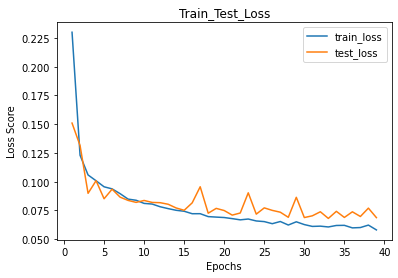

40
Train Epoch: 40 [0/7471 (0%)]	Loss: 0.057414
Train Epoch: 40 [160/7471 (2%)]	Loss: 0.056091
Train Epoch: 40 [320/7471 (4%)]	Loss: 0.056946
Train Epoch: 40 [480/7471 (6%)]	Loss: 0.054033
Train Epoch: 40 [640/7471 (9%)]	Loss: 0.052708
Train Epoch: 40 [800/7471 (11%)]	Loss: 0.056555
Train Epoch: 40 [960/7471 (13%)]	Loss: 0.056502
Train Epoch: 40 [1120/7471 (15%)]	Loss: 0.054934
Train Epoch: 40 [1280/7471 (17%)]	Loss: 0.063900
Train Epoch: 40 [1440/7471 (19%)]	Loss: 0.056200
Train Epoch: 40 [1600/7471 (21%)]	Loss: 0.056274
Train Epoch: 40 [1760/7471 (24%)]	Loss: 0.060672
Train Epoch: 40 [1920/7471 (26%)]	Loss: 0.054920
Train Epoch: 40 [2080/7471 (28%)]	Loss: 0.064109
Train Epoch: 40 [2240/7471 (30%)]	Loss: 0.059722
Train Epoch: 40 [2400/7471 (32%)]	Loss: 0.058258
Train Epoch: 40 [2560/7471 (34%)]	Loss: 0.055197
Train Epoch: 40 [2720/7471 (36%)]	Loss: 0.058092
Train Epoch: 40 [2880/7471 (39%)]	Loss: 0.055344
Train Epoch: 40 [3040/7471 (41%)]	Loss: 0.058536
Train Epoch: 40 [3200/7471 (43%

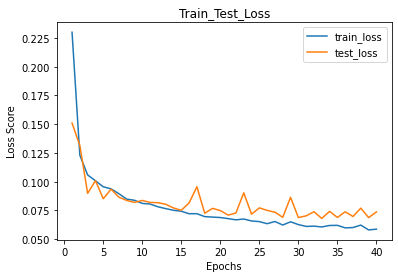

41
Train Epoch: 41 [0/7471 (0%)]	Loss: 0.058589
Train Epoch: 41 [160/7471 (2%)]	Loss: 0.056854
Train Epoch: 41 [320/7471 (4%)]	Loss: 0.054250
Train Epoch: 41 [480/7471 (6%)]	Loss: 0.057175
Train Epoch: 41 [640/7471 (9%)]	Loss: 0.055227
Train Epoch: 41 [800/7471 (11%)]	Loss: 0.051184
Train Epoch: 41 [960/7471 (13%)]	Loss: 0.057578
Train Epoch: 41 [1120/7471 (15%)]	Loss: 0.057576
Train Epoch: 41 [1280/7471 (17%)]	Loss: 0.057918
Train Epoch: 41 [1440/7471 (19%)]	Loss: 0.056426
Train Epoch: 41 [1600/7471 (21%)]	Loss: 0.056625
Train Epoch: 41 [1760/7471 (24%)]	Loss: 0.059318
Train Epoch: 41 [1920/7471 (26%)]	Loss: 0.072735
Train Epoch: 41 [2080/7471 (28%)]	Loss: 0.073680
Train Epoch: 41 [2240/7471 (30%)]	Loss: 0.066942
Train Epoch: 41 [2400/7471 (32%)]	Loss: 0.063423
Train Epoch: 41 [2560/7471 (34%)]	Loss: 0.069389
Train Epoch: 41 [2720/7471 (36%)]	Loss: 0.070660
Train Epoch: 41 [2880/7471 (39%)]	Loss: 0.062091
Train Epoch: 41 [3040/7471 (41%)]	Loss: 0.057501
Train Epoch: 41 [3200/7471 (43%

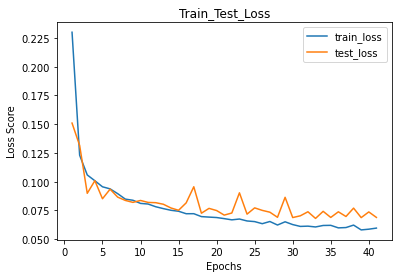

42
Train Epoch: 42 [0/7471 (0%)]	Loss: 0.055638
Train Epoch: 42 [160/7471 (2%)]	Loss: 0.054352
Train Epoch: 42 [320/7471 (4%)]	Loss: 0.059049
Train Epoch: 42 [480/7471 (6%)]	Loss: 0.061337
Train Epoch: 42 [640/7471 (9%)]	Loss: 0.055363
Train Epoch: 42 [800/7471 (11%)]	Loss: 0.054643
Train Epoch: 42 [960/7471 (13%)]	Loss: 0.056809
Train Epoch: 42 [1120/7471 (15%)]	Loss: 0.053436
Train Epoch: 42 [1280/7471 (17%)]	Loss: 0.059715
Train Epoch: 42 [1440/7471 (19%)]	Loss: 0.055458
Train Epoch: 42 [1600/7471 (21%)]	Loss: 0.057022
Train Epoch: 42 [1760/7471 (24%)]	Loss: 0.055230
Train Epoch: 42 [1920/7471 (26%)]	Loss: 0.056549
Train Epoch: 42 [2080/7471 (28%)]	Loss: 0.054597
Train Epoch: 42 [2240/7471 (30%)]	Loss: 0.058182
Train Epoch: 42 [2400/7471 (32%)]	Loss: 0.059404
Train Epoch: 42 [2560/7471 (34%)]	Loss: 0.058430
Train Epoch: 42 [2720/7471 (36%)]	Loss: 0.054812
Train Epoch: 42 [2880/7471 (39%)]	Loss: 0.059371
Train Epoch: 42 [3040/7471 (41%)]	Loss: 0.065550
Train Epoch: 42 [3200/7471 (43%

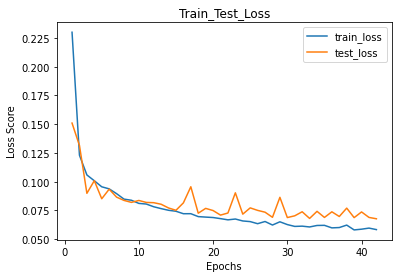

43
Train Epoch: 43 [0/7471 (0%)]	Loss: 0.054815
Train Epoch: 43 [160/7471 (2%)]	Loss: 0.056105
Train Epoch: 43 [320/7471 (4%)]	Loss: 0.060235
Train Epoch: 43 [480/7471 (6%)]	Loss: 0.052027
Train Epoch: 43 [640/7471 (9%)]	Loss: 0.054790
Train Epoch: 43 [800/7471 (11%)]	Loss: 0.056724
Train Epoch: 43 [960/7471 (13%)]	Loss: 0.055209
Train Epoch: 43 [1120/7471 (15%)]	Loss: 0.054888
Train Epoch: 43 [1280/7471 (17%)]	Loss: 0.056324
Train Epoch: 43 [1440/7471 (19%)]	Loss: 0.061376
Train Epoch: 43 [1600/7471 (21%)]	Loss: 0.054914
Train Epoch: 43 [1760/7471 (24%)]	Loss: 0.056727
Train Epoch: 43 [1920/7471 (26%)]	Loss: 0.054170
Train Epoch: 43 [2080/7471 (28%)]	Loss: 0.060982
Train Epoch: 43 [2240/7471 (30%)]	Loss: 0.055213
Train Epoch: 43 [2400/7471 (32%)]	Loss: 0.057208
Train Epoch: 43 [2560/7471 (34%)]	Loss: 0.056975
Train Epoch: 43 [2720/7471 (36%)]	Loss: 0.056168
Train Epoch: 43 [2880/7471 (39%)]	Loss: 0.053079
Train Epoch: 43 [3040/7471 (41%)]	Loss: 0.058467
Train Epoch: 43 [3200/7471 (43%

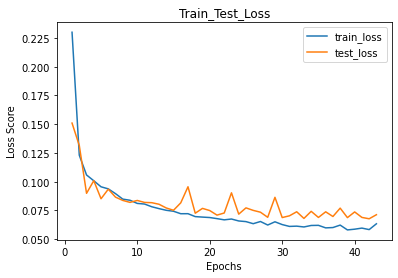

44
Train Epoch: 44 [0/7471 (0%)]	Loss: 0.058822
Train Epoch: 44 [160/7471 (2%)]	Loss: 0.056570
Train Epoch: 44 [320/7471 (4%)]	Loss: 0.054604
Train Epoch: 44 [480/7471 (6%)]	Loss: 0.054980
Train Epoch: 44 [640/7471 (9%)]	Loss: 0.053725
Train Epoch: 44 [800/7471 (11%)]	Loss: 0.055618
Train Epoch: 44 [960/7471 (13%)]	Loss: 0.057963
Train Epoch: 44 [1120/7471 (15%)]	Loss: 0.058852
Train Epoch: 44 [1280/7471 (17%)]	Loss: 0.055358
Train Epoch: 44 [1440/7471 (19%)]	Loss: 0.055479
Train Epoch: 44 [1600/7471 (21%)]	Loss: 0.058559
Train Epoch: 44 [1760/7471 (24%)]	Loss: 0.053526
Train Epoch: 44 [1920/7471 (26%)]	Loss: 0.056258
Train Epoch: 44 [2080/7471 (28%)]	Loss: 0.054469
Train Epoch: 44 [2240/7471 (30%)]	Loss: 0.055643
Train Epoch: 44 [2400/7471 (32%)]	Loss: 0.056135
Train Epoch: 44 [2560/7471 (34%)]	Loss: 0.054914
Train Epoch: 44 [2720/7471 (36%)]	Loss: 0.052346
Train Epoch: 44 [2880/7471 (39%)]	Loss: 0.054174
Train Epoch: 44 [3040/7471 (41%)]	Loss: 0.052319
Train Epoch: 44 [3200/7471 (43%

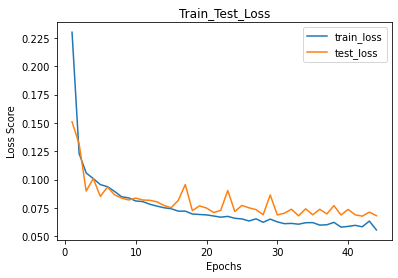

45
Train Epoch: 45 [0/7471 (0%)]	Loss: 0.052961
Train Epoch: 45 [160/7471 (2%)]	Loss: 0.054061
Train Epoch: 45 [320/7471 (4%)]	Loss: 0.057378
Train Epoch: 45 [480/7471 (6%)]	Loss: 0.055161
Train Epoch: 45 [640/7471 (9%)]	Loss: 0.056833
Train Epoch: 45 [800/7471 (11%)]	Loss: 0.053567
Train Epoch: 45 [960/7471 (13%)]	Loss: 0.052819
Train Epoch: 45 [1120/7471 (15%)]	Loss: 0.052967
Train Epoch: 45 [1280/7471 (17%)]	Loss: 0.055981
Train Epoch: 45 [1440/7471 (19%)]	Loss: 0.050363
Train Epoch: 45 [1600/7471 (21%)]	Loss: 0.051330
Train Epoch: 45 [1760/7471 (24%)]	Loss: 0.058083
Train Epoch: 45 [1920/7471 (26%)]	Loss: 0.053666
Train Epoch: 45 [2080/7471 (28%)]	Loss: 0.057218
Train Epoch: 45 [2240/7471 (30%)]	Loss: 0.053939
Train Epoch: 45 [2400/7471 (32%)]	Loss: 0.055656
Train Epoch: 45 [2560/7471 (34%)]	Loss: 0.055151
Train Epoch: 45 [2720/7471 (36%)]	Loss: 0.060964
Train Epoch: 45 [2880/7471 (39%)]	Loss: 0.062022
Train Epoch: 45 [3040/7471 (41%)]	Loss: 0.059690
Train Epoch: 45 [3200/7471 (43%

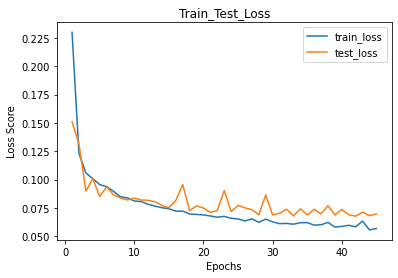

46
Train Epoch: 46 [0/7471 (0%)]	Loss: 0.056483
Train Epoch: 46 [160/7471 (2%)]	Loss: 0.055711
Train Epoch: 46 [320/7471 (4%)]	Loss: 0.055762
Train Epoch: 46 [480/7471 (6%)]	Loss: 0.054649
Train Epoch: 46 [640/7471 (9%)]	Loss: 0.058341
Train Epoch: 46 [800/7471 (11%)]	Loss: 0.056714
Train Epoch: 46 [960/7471 (13%)]	Loss: 0.059600
Train Epoch: 46 [1120/7471 (15%)]	Loss: 0.069465
Train Epoch: 46 [1280/7471 (17%)]	Loss: 0.064341
Train Epoch: 46 [1440/7471 (19%)]	Loss: 0.058616
Train Epoch: 46 [1600/7471 (21%)]	Loss: 0.053298
Train Epoch: 46 [1760/7471 (24%)]	Loss: 0.052283
Train Epoch: 46 [1920/7471 (26%)]	Loss: 0.057472
Train Epoch: 46 [2080/7471 (28%)]	Loss: 0.056950
Train Epoch: 46 [2240/7471 (30%)]	Loss: 0.057110
Train Epoch: 46 [2400/7471 (32%)]	Loss: 0.055774
Train Epoch: 46 [2560/7471 (34%)]	Loss: 0.056172
Train Epoch: 46 [2720/7471 (36%)]	Loss: 0.054251
Train Epoch: 46 [2880/7471 (39%)]	Loss: 0.052791
Train Epoch: 46 [3040/7471 (41%)]	Loss: 0.070102
Train Epoch: 46 [3200/7471 (43%

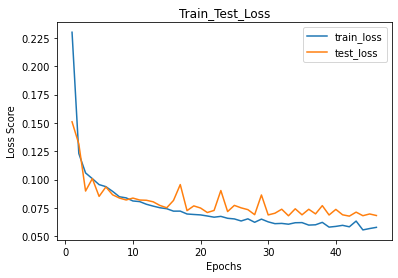

47
Train Epoch: 47 [0/7471 (0%)]	Loss: 0.054363
Train Epoch: 47 [160/7471 (2%)]	Loss: 0.054894
Train Epoch: 47 [320/7471 (4%)]	Loss: 0.052884
Train Epoch: 47 [480/7471 (6%)]	Loss: 0.053849
Train Epoch: 47 [640/7471 (9%)]	Loss: 0.058001
Train Epoch: 47 [800/7471 (11%)]	Loss: 0.054733
Train Epoch: 47 [960/7471 (13%)]	Loss: 0.054153
Train Epoch: 47 [1120/7471 (15%)]	Loss: 0.055523
Train Epoch: 47 [1280/7471 (17%)]	Loss: 0.071447
Train Epoch: 47 [1440/7471 (19%)]	Loss: 0.060155
Train Epoch: 47 [1600/7471 (21%)]	Loss: 0.060953
Train Epoch: 47 [1760/7471 (24%)]	Loss: 0.085285
Train Epoch: 47 [1920/7471 (26%)]	Loss: 0.068157
Train Epoch: 47 [2080/7471 (28%)]	Loss: 0.053535
Train Epoch: 47 [2240/7471 (30%)]	Loss: 0.075186
Train Epoch: 47 [2400/7471 (32%)]	Loss: 0.055545
Train Epoch: 47 [2560/7471 (34%)]	Loss: 0.062990
Train Epoch: 47 [2720/7471 (36%)]	Loss: 0.054623
Train Epoch: 47 [2880/7471 (39%)]	Loss: 0.063569
Train Epoch: 47 [3040/7471 (41%)]	Loss: 0.059686
Train Epoch: 47 [3200/7471 (43%

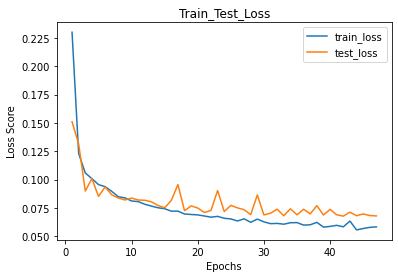

48
Train Epoch: 48 [0/7471 (0%)]	Loss: 0.054841
Train Epoch: 48 [160/7471 (2%)]	Loss: 0.051615
Train Epoch: 48 [320/7471 (4%)]	Loss: 0.060456
Train Epoch: 48 [480/7471 (6%)]	Loss: 0.055094
Train Epoch: 48 [640/7471 (9%)]	Loss: 0.056200
Train Epoch: 48 [800/7471 (11%)]	Loss: 0.054824
Train Epoch: 48 [960/7471 (13%)]	Loss: 0.055874
Train Epoch: 48 [1120/7471 (15%)]	Loss: 0.050187
Train Epoch: 48 [1280/7471 (17%)]	Loss: 0.051947
Train Epoch: 48 [1440/7471 (19%)]	Loss: 0.054298
Train Epoch: 48 [1600/7471 (21%)]	Loss: 0.054111
Train Epoch: 48 [1760/7471 (24%)]	Loss: 0.054634
Train Epoch: 48 [1920/7471 (26%)]	Loss: 0.054038
Train Epoch: 48 [2080/7471 (28%)]	Loss: 0.057554
Train Epoch: 48 [2240/7471 (30%)]	Loss: 0.053388
Train Epoch: 48 [2400/7471 (32%)]	Loss: 0.056531
Train Epoch: 48 [2560/7471 (34%)]	Loss: 0.053952
Train Epoch: 48 [2720/7471 (36%)]	Loss: 0.063328
Train Epoch: 48 [2880/7471 (39%)]	Loss: 0.055134
Train Epoch: 48 [3040/7471 (41%)]	Loss: 0.066079
Train Epoch: 48 [3200/7471 (43%

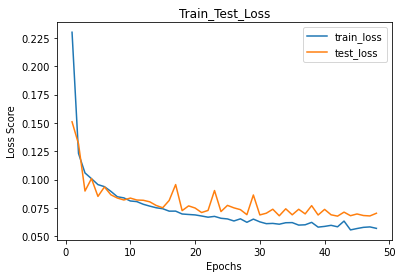

49
Train Epoch: 49 [0/7471 (0%)]	Loss: 0.056553
Train Epoch: 49 [160/7471 (2%)]	Loss: 0.053478
Train Epoch: 49 [320/7471 (4%)]	Loss: 0.059533
Train Epoch: 49 [480/7471 (6%)]	Loss: 0.056368
Train Epoch: 49 [640/7471 (9%)]	Loss: 0.062066
Train Epoch: 49 [800/7471 (11%)]	Loss: 0.052022
Train Epoch: 49 [960/7471 (13%)]	Loss: 0.056545
Train Epoch: 49 [1120/7471 (15%)]	Loss: 0.052592
Train Epoch: 49 [1280/7471 (17%)]	Loss: 0.052817
Train Epoch: 49 [1440/7471 (19%)]	Loss: 0.052653
Train Epoch: 49 [1600/7471 (21%)]	Loss: 0.052809
Train Epoch: 49 [1760/7471 (24%)]	Loss: 0.055887
Train Epoch: 49 [1920/7471 (26%)]	Loss: 0.054165
Train Epoch: 49 [2080/7471 (28%)]	Loss: 0.053516
Train Epoch: 49 [2240/7471 (30%)]	Loss: 0.056717
Train Epoch: 49 [2400/7471 (32%)]	Loss: 0.052825
Train Epoch: 49 [2560/7471 (34%)]	Loss: 0.053048
Train Epoch: 49 [2720/7471 (36%)]	Loss: 0.059027
Train Epoch: 49 [2880/7471 (39%)]	Loss: 0.058286
Train Epoch: 49 [3040/7471 (41%)]	Loss: 0.053328
Train Epoch: 49 [3200/7471 (43%

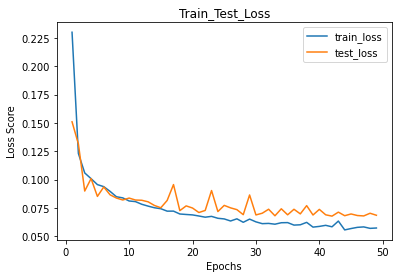

50
Train Epoch: 50 [0/7471 (0%)]	Loss: 0.055391
Train Epoch: 50 [160/7471 (2%)]	Loss: 0.057319
Train Epoch: 50 [320/7471 (4%)]	Loss: 0.057840
Train Epoch: 50 [480/7471 (6%)]	Loss: 0.055624
Train Epoch: 50 [640/7471 (9%)]	Loss: 0.056196
Train Epoch: 50 [800/7471 (11%)]	Loss: 0.057480
Train Epoch: 50 [960/7471 (13%)]	Loss: 0.053758
Train Epoch: 50 [1120/7471 (15%)]	Loss: 0.055732
Train Epoch: 50 [1280/7471 (17%)]	Loss: 0.054229
Train Epoch: 50 [1440/7471 (19%)]	Loss: 0.053916
Train Epoch: 50 [1600/7471 (21%)]	Loss: 0.056409
Train Epoch: 50 [1760/7471 (24%)]	Loss: 0.057878
Train Epoch: 50 [1920/7471 (26%)]	Loss: 0.056113
Train Epoch: 50 [2080/7471 (28%)]	Loss: 0.056288
Train Epoch: 50 [2240/7471 (30%)]	Loss: 0.054759
Train Epoch: 50 [2400/7471 (32%)]	Loss: 0.051811
Train Epoch: 50 [2560/7471 (34%)]	Loss: 0.051422
Train Epoch: 50 [2720/7471 (36%)]	Loss: 0.053212
Train Epoch: 50 [2880/7471 (39%)]	Loss: 0.054087
Train Epoch: 50 [3040/7471 (41%)]	Loss: 0.054431
Train Epoch: 50 [3200/7471 (43%

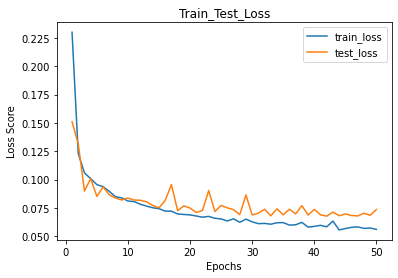

51
Train Epoch: 51 [0/7471 (0%)]	Loss: 0.060708
Train Epoch: 51 [160/7471 (2%)]	Loss: 0.053963
Train Epoch: 51 [320/7471 (4%)]	Loss: 0.054344
Train Epoch: 51 [480/7471 (6%)]	Loss: 0.057415
Train Epoch: 51 [640/7471 (9%)]	Loss: 0.053646
Train Epoch: 51 [800/7471 (11%)]	Loss: 0.086912
Train Epoch: 51 [960/7471 (13%)]	Loss: 0.055678
Train Epoch: 51 [1120/7471 (15%)]	Loss: 0.077230
Train Epoch: 51 [1280/7471 (17%)]	Loss: 0.057223
Train Epoch: 51 [1440/7471 (19%)]	Loss: 0.056386
Train Epoch: 51 [1600/7471 (21%)]	Loss: 0.055310
Train Epoch: 51 [1760/7471 (24%)]	Loss: 0.056353
Train Epoch: 51 [1920/7471 (26%)]	Loss: 0.055000
Train Epoch: 51 [2080/7471 (28%)]	Loss: 0.050555
Train Epoch: 51 [2240/7471 (30%)]	Loss: 0.055432
Train Epoch: 51 [2400/7471 (32%)]	Loss: 0.052164
Train Epoch: 51 [2560/7471 (34%)]	Loss: 0.050890
Train Epoch: 51 [2720/7471 (36%)]	Loss: 0.055268
Train Epoch: 51 [2880/7471 (39%)]	Loss: 0.056266
Train Epoch: 51 [3040/7471 (41%)]	Loss: 0.059900
Train Epoch: 51 [3200/7471 (43%

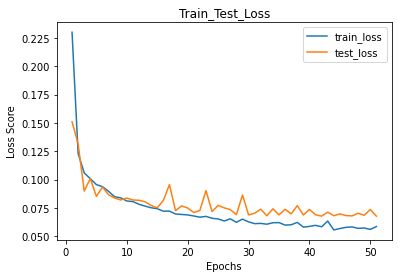

52
Train Epoch: 52 [0/7471 (0%)]	Loss: 0.055548
Train Epoch: 52 [160/7471 (2%)]	Loss: 0.056213
Train Epoch: 52 [320/7471 (4%)]	Loss: 0.053362
Train Epoch: 52 [480/7471 (6%)]	Loss: 0.061026
Train Epoch: 52 [640/7471 (9%)]	Loss: 0.053106
Train Epoch: 52 [800/7471 (11%)]	Loss: 0.050815
Train Epoch: 52 [960/7471 (13%)]	Loss: 0.053426
Train Epoch: 52 [1120/7471 (15%)]	Loss: 0.055794
Train Epoch: 52 [1280/7471 (17%)]	Loss: 0.056679
Train Epoch: 52 [1440/7471 (19%)]	Loss: 0.068223
Train Epoch: 52 [1600/7471 (21%)]	Loss: 0.061746
Train Epoch: 52 [1760/7471 (24%)]	Loss: 0.052699
Train Epoch: 52 [1920/7471 (26%)]	Loss: 0.058929
Train Epoch: 52 [2080/7471 (28%)]	Loss: 0.053623
Train Epoch: 52 [2240/7471 (30%)]	Loss: 0.054560
Train Epoch: 52 [2400/7471 (32%)]	Loss: 0.052127
Train Epoch: 52 [2560/7471 (34%)]	Loss: 0.051424
Train Epoch: 52 [2720/7471 (36%)]	Loss: 0.051251
Train Epoch: 52 [2880/7471 (39%)]	Loss: 0.050567
Train Epoch: 52 [3040/7471 (41%)]	Loss: 0.053085
Train Epoch: 52 [3200/7471 (43%

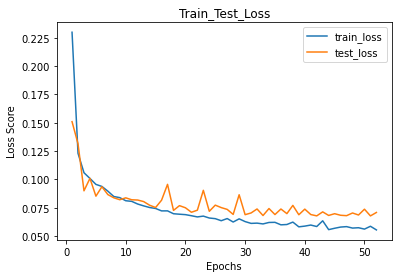

53
Train Epoch: 53 [0/7471 (0%)]	Loss: 0.058199
Train Epoch: 53 [160/7471 (2%)]	Loss: 0.098980
Train Epoch: 53 [320/7471 (4%)]	Loss: 0.060173
Train Epoch: 53 [480/7471 (6%)]	Loss: 0.055391
Train Epoch: 53 [640/7471 (9%)]	Loss: 0.064538
Train Epoch: 53 [800/7471 (11%)]	Loss: 0.057511
Train Epoch: 53 [960/7471 (13%)]	Loss: 0.059701
Train Epoch: 53 [1120/7471 (15%)]	Loss: 0.054668
Train Epoch: 53 [1280/7471 (17%)]	Loss: 0.052130
Train Epoch: 53 [1440/7471 (19%)]	Loss: 0.055428
Train Epoch: 53 [1600/7471 (21%)]	Loss: 0.052508
Train Epoch: 53 [1760/7471 (24%)]	Loss: 0.054641
Train Epoch: 53 [1920/7471 (26%)]	Loss: 0.054162
Train Epoch: 53 [2080/7471 (28%)]	Loss: 0.053739
Train Epoch: 53 [2240/7471 (30%)]	Loss: 0.053278
Train Epoch: 53 [2400/7471 (32%)]	Loss: 0.055635
Train Epoch: 53 [2560/7471 (34%)]	Loss: 0.066171
Train Epoch: 53 [2720/7471 (36%)]	Loss: 0.051242
Train Epoch: 53 [2880/7471 (39%)]	Loss: 0.057036
Train Epoch: 53 [3040/7471 (41%)]	Loss: 0.060192
Train Epoch: 53 [3200/7471 (43%

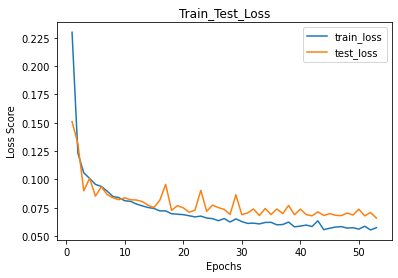

54
Train Epoch: 54 [0/7471 (0%)]	Loss: 0.053059
Train Epoch: 54 [160/7471 (2%)]	Loss: 0.049821
Train Epoch: 54 [320/7471 (4%)]	Loss: 0.063334
Train Epoch: 54 [480/7471 (6%)]	Loss: 0.055377
Train Epoch: 54 [640/7471 (9%)]	Loss: 0.060618
Train Epoch: 54 [800/7471 (11%)]	Loss: 0.052416
Train Epoch: 54 [960/7471 (13%)]	Loss: 0.052797
Train Epoch: 54 [1120/7471 (15%)]	Loss: 0.049999
Train Epoch: 54 [1280/7471 (17%)]	Loss: 0.051085
Train Epoch: 54 [1440/7471 (19%)]	Loss: 0.053052
Train Epoch: 54 [1600/7471 (21%)]	Loss: 0.059627
Train Epoch: 54 [1760/7471 (24%)]	Loss: 0.054478
Train Epoch: 54 [1920/7471 (26%)]	Loss: 0.051398
Train Epoch: 54 [2080/7471 (28%)]	Loss: 0.053849
Train Epoch: 54 [2240/7471 (30%)]	Loss: 0.051532
Train Epoch: 54 [2400/7471 (32%)]	Loss: 0.055049
Train Epoch: 54 [2560/7471 (34%)]	Loss: 0.058406
Train Epoch: 54 [2720/7471 (36%)]	Loss: 0.051880
Train Epoch: 54 [2880/7471 (39%)]	Loss: 0.056343
Train Epoch: 54 [3040/7471 (41%)]	Loss: 0.052855
Train Epoch: 54 [3200/7471 (43%

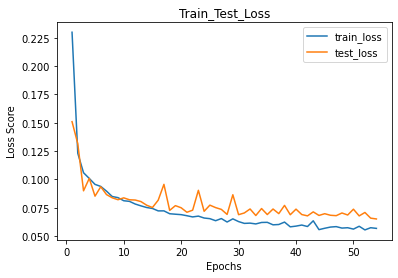

55
Train Epoch: 55 [0/7471 (0%)]	Loss: 0.051088
Train Epoch: 55 [160/7471 (2%)]	Loss: 0.053532
Train Epoch: 55 [320/7471 (4%)]	Loss: 0.054329
Train Epoch: 55 [480/7471 (6%)]	Loss: 0.053156
Train Epoch: 55 [640/7471 (9%)]	Loss: 0.059898
Train Epoch: 55 [800/7471 (11%)]	Loss: 0.052935
Train Epoch: 55 [960/7471 (13%)]	Loss: 0.058856
Train Epoch: 55 [1120/7471 (15%)]	Loss: 0.057714
Train Epoch: 55 [1280/7471 (17%)]	Loss: 0.052983
Train Epoch: 55 [1440/7471 (19%)]	Loss: 0.055857
Train Epoch: 55 [1600/7471 (21%)]	Loss: 0.053331
Train Epoch: 55 [1760/7471 (24%)]	Loss: 0.051449
Train Epoch: 55 [1920/7471 (26%)]	Loss: 0.053653
Train Epoch: 55 [2080/7471 (28%)]	Loss: 0.059444
Train Epoch: 55 [2240/7471 (30%)]	Loss: 0.053548
Train Epoch: 55 [2400/7471 (32%)]	Loss: 0.051948
Train Epoch: 55 [2560/7471 (34%)]	Loss: 0.052647
Train Epoch: 55 [2720/7471 (36%)]	Loss: 0.051317
Train Epoch: 55 [2880/7471 (39%)]	Loss: 0.050973
Train Epoch: 55 [3040/7471 (41%)]	Loss: 0.054552
Train Epoch: 55 [3200/7471 (43%

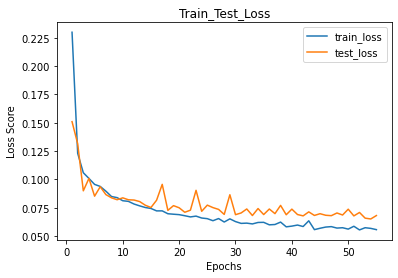

56
Train Epoch: 56 [0/7471 (0%)]	Loss: 0.053546
Train Epoch: 56 [160/7471 (2%)]	Loss: 0.054308
Train Epoch: 56 [320/7471 (4%)]	Loss: 0.058346
Train Epoch: 56 [480/7471 (6%)]	Loss: 0.053091
Train Epoch: 56 [640/7471 (9%)]	Loss: 0.051693
Train Epoch: 56 [800/7471 (11%)]	Loss: 0.050478
Train Epoch: 56 [960/7471 (13%)]	Loss: 0.055368
Train Epoch: 56 [1120/7471 (15%)]	Loss: 0.053972
Train Epoch: 56 [1280/7471 (17%)]	Loss: 0.051402
Train Epoch: 56 [1440/7471 (19%)]	Loss: 0.051591
Train Epoch: 56 [1600/7471 (21%)]	Loss: 0.057060
Train Epoch: 56 [1760/7471 (24%)]	Loss: 0.053476
Train Epoch: 56 [1920/7471 (26%)]	Loss: 0.069103
Train Epoch: 56 [2080/7471 (28%)]	Loss: 0.055327
Train Epoch: 56 [2240/7471 (30%)]	Loss: 0.065784
Train Epoch: 56 [2400/7471 (32%)]	Loss: 0.052110
Train Epoch: 56 [2560/7471 (34%)]	Loss: 0.055386
Train Epoch: 56 [2720/7471 (36%)]	Loss: 0.057925
Train Epoch: 56 [2880/7471 (39%)]	Loss: 0.057399
Train Epoch: 56 [3040/7471 (41%)]	Loss: 0.053958
Train Epoch: 56 [3200/7471 (43%

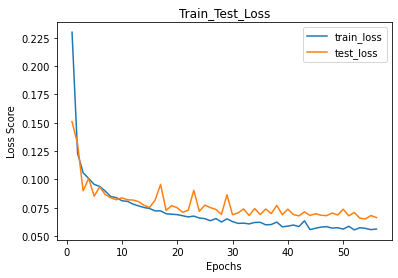

57
Train Epoch: 57 [0/7471 (0%)]	Loss: 0.052562
Train Epoch: 57 [160/7471 (2%)]	Loss: 0.051549
Train Epoch: 57 [320/7471 (4%)]	Loss: 0.055483
Train Epoch: 57 [480/7471 (6%)]	Loss: 0.060293
Train Epoch: 57 [640/7471 (9%)]	Loss: 0.058146
Train Epoch: 57 [800/7471 (11%)]	Loss: 0.051655
Train Epoch: 57 [960/7471 (13%)]	Loss: 0.056130
Train Epoch: 57 [1120/7471 (15%)]	Loss: 0.060177
Train Epoch: 57 [1280/7471 (17%)]	Loss: 0.055258
Train Epoch: 57 [1440/7471 (19%)]	Loss: 0.053968
Train Epoch: 57 [1600/7471 (21%)]	Loss: 0.052798
Train Epoch: 57 [1760/7471 (24%)]	Loss: 0.049857
Train Epoch: 57 [1920/7471 (26%)]	Loss: 0.050096
Train Epoch: 57 [2080/7471 (28%)]	Loss: 0.052761
Train Epoch: 57 [2240/7471 (30%)]	Loss: 0.051865
Train Epoch: 57 [2400/7471 (32%)]	Loss: 0.051321
Train Epoch: 57 [2560/7471 (34%)]	Loss: 0.051910
Train Epoch: 57 [2720/7471 (36%)]	Loss: 0.053276
Train Epoch: 57 [2880/7471 (39%)]	Loss: 0.055186
Train Epoch: 57 [3040/7471 (41%)]	Loss: 0.051218
Train Epoch: 57 [3200/7471 (43%

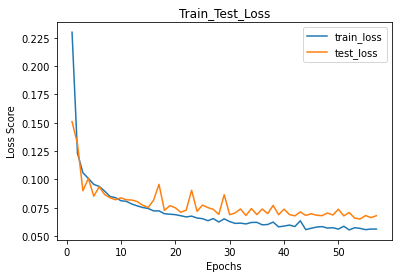

58
Train Epoch: 58 [0/7471 (0%)]	Loss: 0.054090
Train Epoch: 58 [160/7471 (2%)]	Loss: 0.051564
Train Epoch: 58 [320/7471 (4%)]	Loss: 0.055653
Train Epoch: 58 [480/7471 (6%)]	Loss: 0.052833
Train Epoch: 58 [640/7471 (9%)]	Loss: 0.050635
Train Epoch: 58 [800/7471 (11%)]	Loss: 0.056558
Train Epoch: 58 [960/7471 (13%)]	Loss: 0.058122
Train Epoch: 58 [1120/7471 (15%)]	Loss: 0.059804
Train Epoch: 58 [1280/7471 (17%)]	Loss: 0.051428
Train Epoch: 58 [1440/7471 (19%)]	Loss: 0.055543
Train Epoch: 58 [1600/7471 (21%)]	Loss: 0.053434
Train Epoch: 58 [1760/7471 (24%)]	Loss: 0.055452
Train Epoch: 58 [1920/7471 (26%)]	Loss: 0.060705
Train Epoch: 58 [2080/7471 (28%)]	Loss: 0.071965
Train Epoch: 58 [2240/7471 (30%)]	Loss: 0.051390
Train Epoch: 58 [2400/7471 (32%)]	Loss: 0.056426
Train Epoch: 58 [2560/7471 (34%)]	Loss: 0.051160
Train Epoch: 58 [2720/7471 (36%)]	Loss: 0.056096
Train Epoch: 58 [2880/7471 (39%)]	Loss: 0.059892
Train Epoch: 58 [3040/7471 (41%)]	Loss: 0.053386
Train Epoch: 58 [3200/7471 (43%

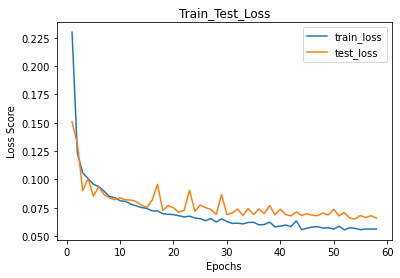

59
Train Epoch: 59 [0/7471 (0%)]	Loss: 0.052037
Train Epoch: 59 [160/7471 (2%)]	Loss: 0.052965
Train Epoch: 59 [320/7471 (4%)]	Loss: 0.051270
Train Epoch: 59 [480/7471 (6%)]	Loss: 0.049596
Train Epoch: 59 [640/7471 (9%)]	Loss: 0.052446
Train Epoch: 59 [800/7471 (11%)]	Loss: 0.051712
Train Epoch: 59 [960/7471 (13%)]	Loss: 0.052498
Train Epoch: 59 [1120/7471 (15%)]	Loss: 0.079848
Train Epoch: 59 [1280/7471 (17%)]	Loss: 0.073324
Train Epoch: 59 [1440/7471 (19%)]	Loss: 0.062913
Train Epoch: 59 [1600/7471 (21%)]	Loss: 0.061379
Train Epoch: 59 [1760/7471 (24%)]	Loss: 0.053669
Train Epoch: 59 [1920/7471 (26%)]	Loss: 0.056416
Train Epoch: 59 [2080/7471 (28%)]	Loss: 0.057197
Train Epoch: 59 [2240/7471 (30%)]	Loss: 0.055559
Train Epoch: 59 [2400/7471 (32%)]	Loss: 0.053095
Train Epoch: 59 [2560/7471 (34%)]	Loss: 0.056057
Train Epoch: 59 [2720/7471 (36%)]	Loss: 0.056233
Train Epoch: 59 [2880/7471 (39%)]	Loss: 0.061377
Train Epoch: 59 [3040/7471 (41%)]	Loss: 0.052706
Train Epoch: 59 [3200/7471 (43%

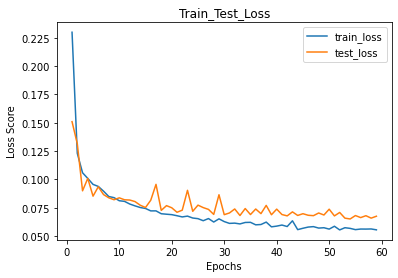

60
Train Epoch: 60 [0/7471 (0%)]	Loss: 0.052007
Train Epoch: 60 [160/7471 (2%)]	Loss: 0.054508
Train Epoch: 60 [320/7471 (4%)]	Loss: 0.052230
Train Epoch: 60 [480/7471 (6%)]	Loss: 0.051604
Train Epoch: 60 [640/7471 (9%)]	Loss: 0.052863
Train Epoch: 60 [800/7471 (11%)]	Loss: 0.056694
Train Epoch: 60 [960/7471 (13%)]	Loss: 0.050648
Train Epoch: 60 [1120/7471 (15%)]	Loss: 0.066135
Train Epoch: 60 [1280/7471 (17%)]	Loss: 0.058583
Train Epoch: 60 [1440/7471 (19%)]	Loss: 0.055960
Train Epoch: 60 [1600/7471 (21%)]	Loss: 0.054302
Train Epoch: 60 [1760/7471 (24%)]	Loss: 0.054506
Train Epoch: 60 [1920/7471 (26%)]	Loss: 0.052455
Train Epoch: 60 [2080/7471 (28%)]	Loss: 0.064749
Train Epoch: 60 [2240/7471 (30%)]	Loss: 0.052653
Train Epoch: 60 [2400/7471 (32%)]	Loss: 0.050732
Train Epoch: 60 [2560/7471 (34%)]	Loss: 0.056716
Train Epoch: 60 [2720/7471 (36%)]	Loss: 0.051838
Train Epoch: 60 [2880/7471 (39%)]	Loss: 0.057635
Train Epoch: 60 [3040/7471 (41%)]	Loss: 0.057201
Train Epoch: 60 [3200/7471 (43%

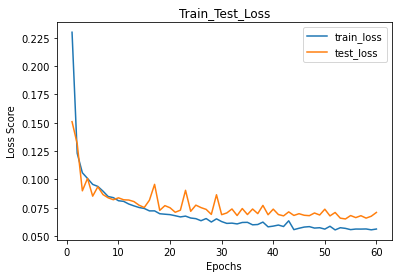

61
Train Epoch: 61 [0/7471 (0%)]	Loss: 0.055704
Train Epoch: 61 [160/7471 (2%)]	Loss: 0.055476
Train Epoch: 61 [320/7471 (4%)]	Loss: 0.051770
Train Epoch: 61 [480/7471 (6%)]	Loss: 0.051765
Train Epoch: 61 [640/7471 (9%)]	Loss: 0.051331
Train Epoch: 61 [800/7471 (11%)]	Loss: 0.062248
Train Epoch: 61 [960/7471 (13%)]	Loss: 0.049848
Train Epoch: 61 [1120/7471 (15%)]	Loss: 0.057593
Train Epoch: 61 [1280/7471 (17%)]	Loss: 0.052950
Train Epoch: 61 [1440/7471 (19%)]	Loss: 0.054079
Train Epoch: 61 [1600/7471 (21%)]	Loss: 0.051302
Train Epoch: 61 [1760/7471 (24%)]	Loss: 0.053073
Train Epoch: 61 [1920/7471 (26%)]	Loss: 0.051407
Train Epoch: 61 [2080/7471 (28%)]	Loss: 0.051397
Train Epoch: 61 [2240/7471 (30%)]	Loss: 0.052023
Train Epoch: 61 [2400/7471 (32%)]	Loss: 0.051065
Train Epoch: 61 [2560/7471 (34%)]	Loss: 0.057684
Train Epoch: 61 [2720/7471 (36%)]	Loss: 0.052149
Train Epoch: 61 [2880/7471 (39%)]	Loss: 0.057964
Train Epoch: 61 [3040/7471 (41%)]	Loss: 0.060702
Train Epoch: 61 [3200/7471 (43%

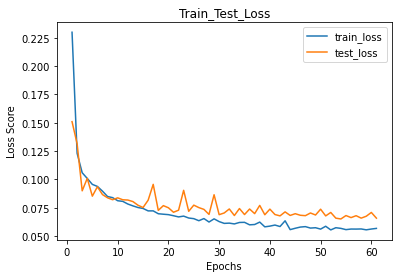

62
Train Epoch: 62 [0/7471 (0%)]	Loss: 0.051593
Train Epoch: 62 [160/7471 (2%)]	Loss: 0.062126
Train Epoch: 62 [320/7471 (4%)]	Loss: 0.059416
Train Epoch: 62 [480/7471 (6%)]	Loss: 0.054077
Train Epoch: 62 [640/7471 (9%)]	Loss: 0.061519
Train Epoch: 62 [800/7471 (11%)]	Loss: 0.054958
Train Epoch: 62 [960/7471 (13%)]	Loss: 0.049987
Train Epoch: 62 [1120/7471 (15%)]	Loss: 0.054760
Train Epoch: 62 [1280/7471 (17%)]	Loss: 0.055490
Train Epoch: 62 [1440/7471 (19%)]	Loss: 0.056946
Train Epoch: 62 [1600/7471 (21%)]	Loss: 0.057165
Train Epoch: 62 [1760/7471 (24%)]	Loss: 0.051732
Train Epoch: 62 [1920/7471 (26%)]	Loss: 0.057093
Train Epoch: 62 [2080/7471 (28%)]	Loss: 0.054516
Train Epoch: 62 [2240/7471 (30%)]	Loss: 0.053432
Train Epoch: 62 [2400/7471 (32%)]	Loss: 0.051729
Train Epoch: 62 [2560/7471 (34%)]	Loss: 0.052738
Train Epoch: 62 [2720/7471 (36%)]	Loss: 0.050856
Train Epoch: 62 [2880/7471 (39%)]	Loss: 0.051779
Train Epoch: 62 [3040/7471 (41%)]	Loss: 0.051289
Train Epoch: 62 [3200/7471 (43%

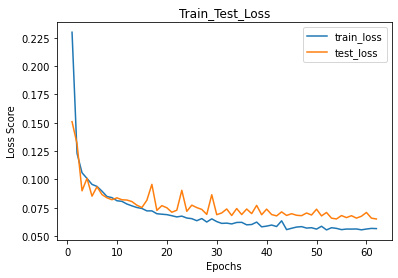

63
Train Epoch: 63 [0/7471 (0%)]	Loss: 0.054290
Train Epoch: 63 [160/7471 (2%)]	Loss: 0.053341
Train Epoch: 63 [320/7471 (4%)]	Loss: 0.056558
Train Epoch: 63 [480/7471 (6%)]	Loss: 0.054293
Train Epoch: 63 [640/7471 (9%)]	Loss: 0.051104
Train Epoch: 63 [800/7471 (11%)]	Loss: 0.048901
Train Epoch: 63 [960/7471 (13%)]	Loss: 0.055061
Train Epoch: 63 [1120/7471 (15%)]	Loss: 0.053211
Train Epoch: 63 [1280/7471 (17%)]	Loss: 0.051739
Train Epoch: 63 [1440/7471 (19%)]	Loss: 0.050532
Train Epoch: 63 [1600/7471 (21%)]	Loss: 0.052401
Train Epoch: 63 [1760/7471 (24%)]	Loss: 0.052994
Train Epoch: 63 [1920/7471 (26%)]	Loss: 0.052724
Train Epoch: 63 [2080/7471 (28%)]	Loss: 0.053059
Train Epoch: 63 [2240/7471 (30%)]	Loss: 0.051328
Train Epoch: 63 [2400/7471 (32%)]	Loss: 0.058351
Train Epoch: 63 [2560/7471 (34%)]	Loss: 0.053467
Train Epoch: 63 [2720/7471 (36%)]	Loss: 0.052439
Train Epoch: 63 [2880/7471 (39%)]	Loss: 0.051317
Train Epoch: 63 [3040/7471 (41%)]	Loss: 0.050322
Train Epoch: 63 [3200/7471 (43%

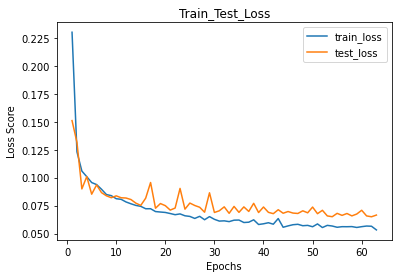

64
Train Epoch: 64 [0/7471 (0%)]	Loss: 0.051042
Train Epoch: 64 [160/7471 (2%)]	Loss: 0.055312
Train Epoch: 64 [320/7471 (4%)]	Loss: 0.052420
Train Epoch: 64 [480/7471 (6%)]	Loss: 0.055638
Train Epoch: 64 [640/7471 (9%)]	Loss: 0.049664
Train Epoch: 64 [800/7471 (11%)]	Loss: 0.048401
Train Epoch: 64 [960/7471 (13%)]	Loss: 0.066414
Train Epoch: 64 [1120/7471 (15%)]	Loss: 0.051461
Train Epoch: 64 [1280/7471 (17%)]	Loss: 0.061127
Train Epoch: 64 [1440/7471 (19%)]	Loss: 0.135343
Train Epoch: 64 [1600/7471 (21%)]	Loss: 0.081357
Train Epoch: 64 [1760/7471 (24%)]	Loss: 0.057239
Train Epoch: 64 [1920/7471 (26%)]	Loss: 0.064907
Train Epoch: 64 [2080/7471 (28%)]	Loss: 0.054844
Train Epoch: 64 [2240/7471 (30%)]	Loss: 0.055847
Train Epoch: 64 [2400/7471 (32%)]	Loss: 0.055775
Train Epoch: 64 [2560/7471 (34%)]	Loss: 0.053515
Train Epoch: 64 [2720/7471 (36%)]	Loss: 0.054000
Train Epoch: 64 [2880/7471 (39%)]	Loss: 0.051845
Train Epoch: 64 [3040/7471 (41%)]	Loss: 0.054691
Train Epoch: 64 [3200/7471 (43%

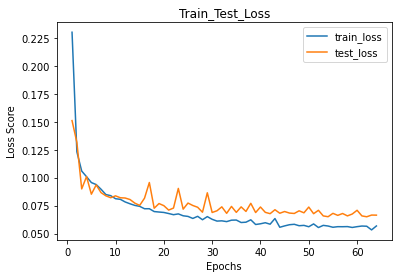

65
Train Epoch: 65 [0/7471 (0%)]	Loss: 0.051937
Train Epoch: 65 [160/7471 (2%)]	Loss: 0.048363
Train Epoch: 65 [320/7471 (4%)]	Loss: 0.050147
Train Epoch: 65 [480/7471 (6%)]	Loss: 0.050027
Train Epoch: 65 [640/7471 (9%)]	Loss: 0.051223
Train Epoch: 65 [800/7471 (11%)]	Loss: 0.050249
Train Epoch: 65 [960/7471 (13%)]	Loss: 0.049293
Train Epoch: 65 [1120/7471 (15%)]	Loss: 0.054088
Train Epoch: 65 [1280/7471 (17%)]	Loss: 0.050950
Train Epoch: 65 [1440/7471 (19%)]	Loss: 0.066895
Train Epoch: 65 [1600/7471 (21%)]	Loss: 0.051354
Train Epoch: 65 [1760/7471 (24%)]	Loss: 0.056942
Train Epoch: 65 [1920/7471 (26%)]	Loss: 0.055627
Train Epoch: 65 [2080/7471 (28%)]	Loss: 0.052537
Train Epoch: 65 [2240/7471 (30%)]	Loss: 0.056970
Train Epoch: 65 [2400/7471 (32%)]	Loss: 0.058022
Train Epoch: 65 [2560/7471 (34%)]	Loss: 0.063944
Train Epoch: 65 [2720/7471 (36%)]	Loss: 0.057077
Train Epoch: 65 [2880/7471 (39%)]	Loss: 0.054102
Train Epoch: 65 [3040/7471 (41%)]	Loss: 0.052280
Train Epoch: 65 [3200/7471 (43%

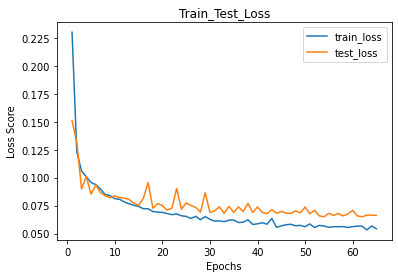

66
Train Epoch: 66 [0/7471 (0%)]	Loss: 0.052459
Train Epoch: 66 [160/7471 (2%)]	Loss: 0.054421
Train Epoch: 66 [320/7471 (4%)]	Loss: 0.066318
Train Epoch: 66 [480/7471 (6%)]	Loss: 0.049532
Train Epoch: 66 [640/7471 (9%)]	Loss: 0.052143
Train Epoch: 66 [800/7471 (11%)]	Loss: 0.051827
Train Epoch: 66 [960/7471 (13%)]	Loss: 0.053872
Train Epoch: 66 [1120/7471 (15%)]	Loss: 0.052730
Train Epoch: 66 [1280/7471 (17%)]	Loss: 0.073288
Train Epoch: 66 [1440/7471 (19%)]	Loss: 0.050353
Train Epoch: 66 [1600/7471 (21%)]	Loss: 0.050837
Train Epoch: 66 [1760/7471 (24%)]	Loss: 0.073144
Train Epoch: 66 [1920/7471 (26%)]	Loss: 0.055716
Train Epoch: 66 [2080/7471 (28%)]	Loss: 0.054906
Train Epoch: 66 [2240/7471 (30%)]	Loss: 0.053294
Train Epoch: 66 [2400/7471 (32%)]	Loss: 0.051642
Train Epoch: 66 [2560/7471 (34%)]	Loss: 0.054165
Train Epoch: 66 [2720/7471 (36%)]	Loss: 0.052194
Train Epoch: 66 [2880/7471 (39%)]	Loss: 0.051164
Train Epoch: 66 [3040/7471 (41%)]	Loss: 0.052970
Train Epoch: 66 [3200/7471 (43%

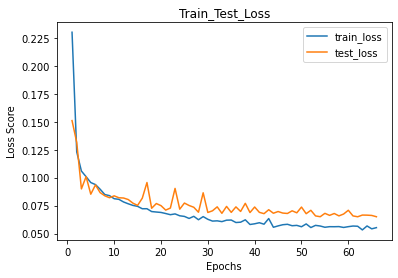

67
Train Epoch: 67 [0/7471 (0%)]	Loss: 0.051834
Train Epoch: 67 [160/7471 (2%)]	Loss: 0.051820
Train Epoch: 67 [320/7471 (4%)]	Loss: 0.056706
Train Epoch: 67 [480/7471 (6%)]	Loss: 0.049357
Train Epoch: 67 [640/7471 (9%)]	Loss: 0.053446
Train Epoch: 67 [800/7471 (11%)]	Loss: 0.051292
Train Epoch: 67 [960/7471 (13%)]	Loss: 0.053120
Train Epoch: 67 [1120/7471 (15%)]	Loss: 0.049035
Train Epoch: 67 [1280/7471 (17%)]	Loss: 0.069509
Train Epoch: 67 [1440/7471 (19%)]	Loss: 0.055361
Train Epoch: 67 [1600/7471 (21%)]	Loss: 0.051663
Train Epoch: 67 [1760/7471 (24%)]	Loss: 0.065611
Train Epoch: 67 [1920/7471 (26%)]	Loss: 0.057449
Train Epoch: 67 [2080/7471 (28%)]	Loss: 0.050448
Train Epoch: 67 [2240/7471 (30%)]	Loss: 0.070331
Train Epoch: 67 [2400/7471 (32%)]	Loss: 0.052122
Train Epoch: 67 [2560/7471 (34%)]	Loss: 0.053281
Train Epoch: 67 [2720/7471 (36%)]	Loss: 0.050807
Train Epoch: 67 [2880/7471 (39%)]	Loss: 0.056376
Train Epoch: 67 [3040/7471 (41%)]	Loss: 0.068573
Train Epoch: 67 [3200/7471 (43%

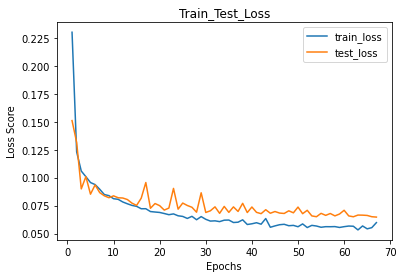

68
Train Epoch: 68 [0/7471 (0%)]	Loss: 0.051164
Train Epoch: 68 [160/7471 (2%)]	Loss: 0.049253
Train Epoch: 68 [320/7471 (4%)]	Loss: 0.050335
Train Epoch: 68 [480/7471 (6%)]	Loss: 0.051586
Train Epoch: 68 [640/7471 (9%)]	Loss: 0.051562
Train Epoch: 68 [800/7471 (11%)]	Loss: 0.051691
Train Epoch: 68 [960/7471 (13%)]	Loss: 0.053248
Train Epoch: 68 [1120/7471 (15%)]	Loss: 0.052341
Train Epoch: 68 [1280/7471 (17%)]	Loss: 0.053270
Train Epoch: 68 [1440/7471 (19%)]	Loss: 0.050233
Train Epoch: 68 [1600/7471 (21%)]	Loss: 0.052571
Train Epoch: 68 [1760/7471 (24%)]	Loss: 0.049674
Train Epoch: 68 [1920/7471 (26%)]	Loss: 0.048286
Train Epoch: 68 [2080/7471 (28%)]	Loss: 0.051204
Train Epoch: 68 [2240/7471 (30%)]	Loss: 0.051472
Train Epoch: 68 [2400/7471 (32%)]	Loss: 0.049575
Train Epoch: 68 [2560/7471 (34%)]	Loss: 0.051609
Train Epoch: 68 [2720/7471 (36%)]	Loss: 0.054136
Train Epoch: 68 [2880/7471 (39%)]	Loss: 0.049689
Train Epoch: 68 [3040/7471 (41%)]	Loss: 0.052319
Train Epoch: 68 [3200/7471 (43%

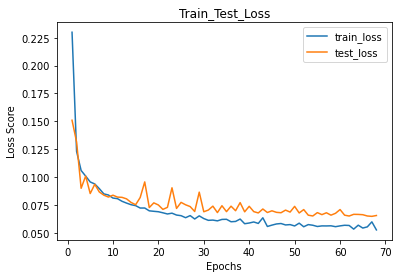

69
Train Epoch: 69 [0/7471 (0%)]	Loss: 0.051400
Train Epoch: 69 [160/7471 (2%)]	Loss: 0.052233
Train Epoch: 69 [320/7471 (4%)]	Loss: 0.051712
Train Epoch: 69 [480/7471 (6%)]	Loss: 0.056938
Train Epoch: 69 [640/7471 (9%)]	Loss: 0.049204
Train Epoch: 69 [800/7471 (11%)]	Loss: 0.050087
Train Epoch: 69 [960/7471 (13%)]	Loss: 0.058199
Train Epoch: 69 [1120/7471 (15%)]	Loss: 0.051787
Train Epoch: 69 [1280/7471 (17%)]	Loss: 0.051838
Train Epoch: 69 [1440/7471 (19%)]	Loss: 0.053042
Train Epoch: 69 [1600/7471 (21%)]	Loss: 0.050370
Train Epoch: 69 [1760/7471 (24%)]	Loss: 0.051318
Train Epoch: 69 [1920/7471 (26%)]	Loss: 0.051221
Train Epoch: 69 [2080/7471 (28%)]	Loss: 0.052801
Train Epoch: 69 [2240/7471 (30%)]	Loss: 0.051452
Train Epoch: 69 [2400/7471 (32%)]	Loss: 0.051936
Train Epoch: 69 [2560/7471 (34%)]	Loss: 0.053225
Train Epoch: 69 [2720/7471 (36%)]	Loss: 0.052205
Train Epoch: 69 [2880/7471 (39%)]	Loss: 0.048919
Train Epoch: 69 [3040/7471 (41%)]	Loss: 0.059510
Train Epoch: 69 [3200/7471 (43%

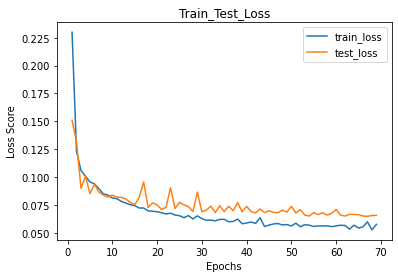

70
Train Epoch: 70 [0/7471 (0%)]	Loss: 0.052490
Train Epoch: 70 [160/7471 (2%)]	Loss: 0.057739
Train Epoch: 70 [320/7471 (4%)]	Loss: 0.056653
Train Epoch: 70 [480/7471 (6%)]	Loss: 0.059139
Train Epoch: 70 [640/7471 (9%)]	Loss: 0.049546
Train Epoch: 70 [800/7471 (11%)]	Loss: 0.047969
Train Epoch: 70 [960/7471 (13%)]	Loss: 0.054074
Train Epoch: 70 [1120/7471 (15%)]	Loss: 0.051531
Train Epoch: 70 [1280/7471 (17%)]	Loss: 0.049436
Train Epoch: 70 [1440/7471 (19%)]	Loss: 0.051775
Train Epoch: 70 [1600/7471 (21%)]	Loss: 0.053371
Train Epoch: 70 [1760/7471 (24%)]	Loss: 0.048587
Train Epoch: 70 [1920/7471 (26%)]	Loss: 0.054681
Train Epoch: 70 [2080/7471 (28%)]	Loss: 0.052065
Train Epoch: 70 [2240/7471 (30%)]	Loss: 0.051619
Train Epoch: 70 [2400/7471 (32%)]	Loss: 0.049251
Train Epoch: 70 [2560/7471 (34%)]	Loss: 0.051568
Train Epoch: 70 [2720/7471 (36%)]	Loss: 0.048867
Train Epoch: 70 [2880/7471 (39%)]	Loss: 0.052248
Train Epoch: 70 [3040/7471 (41%)]	Loss: 0.049719
Train Epoch: 70 [3200/7471 (43%

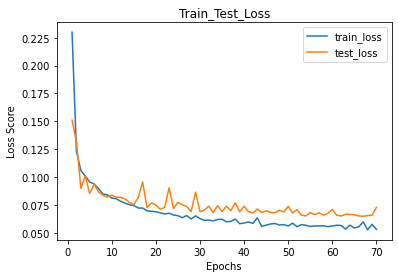

71
Train Epoch: 71 [0/7471 (0%)]	Loss: 0.059002
Train Epoch: 71 [160/7471 (2%)]	Loss: 0.051313
Train Epoch: 71 [320/7471 (4%)]	Loss: 0.053288
Train Epoch: 71 [480/7471 (6%)]	Loss: 0.052376
Train Epoch: 71 [640/7471 (9%)]	Loss: 0.051723
Train Epoch: 71 [800/7471 (11%)]	Loss: 0.048863
Train Epoch: 71 [960/7471 (13%)]	Loss: 0.049578
Train Epoch: 71 [1120/7471 (15%)]	Loss: 0.052000
Train Epoch: 71 [1280/7471 (17%)]	Loss: 0.049002
Train Epoch: 71 [1440/7471 (19%)]	Loss: 0.051252
Train Epoch: 71 [1600/7471 (21%)]	Loss: 0.053236
Train Epoch: 71 [1760/7471 (24%)]	Loss: 0.060187
Train Epoch: 71 [1920/7471 (26%)]	Loss: 0.054188
Train Epoch: 71 [2080/7471 (28%)]	Loss: 0.058471
Train Epoch: 71 [2240/7471 (30%)]	Loss: 0.060164
Train Epoch: 71 [2400/7471 (32%)]	Loss: 0.054351
Train Epoch: 71 [2560/7471 (34%)]	Loss: 0.057314
Train Epoch: 71 [2720/7471 (36%)]	Loss: 0.051786
Train Epoch: 71 [2880/7471 (39%)]	Loss: 0.051532
Train Epoch: 71 [3040/7471 (41%)]	Loss: 0.050735
Train Epoch: 71 [3200/7471 (43%

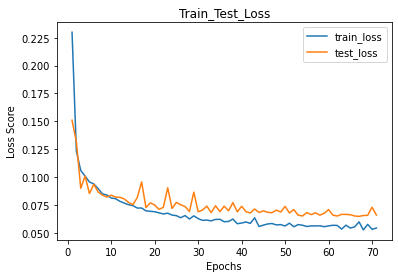

72
Train Epoch: 72 [0/7471 (0%)]	Loss: 0.051778
Train Epoch: 72 [160/7471 (2%)]	Loss: 0.053463
Train Epoch: 72 [320/7471 (4%)]	Loss: 0.050102
Train Epoch: 72 [480/7471 (6%)]	Loss: 0.050165
Train Epoch: 72 [640/7471 (9%)]	Loss: 0.059246
Train Epoch: 72 [800/7471 (11%)]	Loss: 0.050893
Train Epoch: 72 [960/7471 (13%)]	Loss: 0.050697
Train Epoch: 72 [1120/7471 (15%)]	Loss: 0.053365
Train Epoch: 72 [1280/7471 (17%)]	Loss: 0.054742
Train Epoch: 72 [1440/7471 (19%)]	Loss: 0.052652
Train Epoch: 72 [1600/7471 (21%)]	Loss: 0.052978
Train Epoch: 72 [1760/7471 (24%)]	Loss: 0.052843
Train Epoch: 72 [1920/7471 (26%)]	Loss: 0.055279
Train Epoch: 72 [2080/7471 (28%)]	Loss: 0.050457
Train Epoch: 72 [2240/7471 (30%)]	Loss: 0.051937
Train Epoch: 72 [2400/7471 (32%)]	Loss: 0.064117
Train Epoch: 72 [2560/7471 (34%)]	Loss: 0.049988
Train Epoch: 72 [2720/7471 (36%)]	Loss: 0.050489
Train Epoch: 72 [2880/7471 (39%)]	Loss: 0.051734
Train Epoch: 72 [3040/7471 (41%)]	Loss: 0.052551
Train Epoch: 72 [3200/7471 (43%

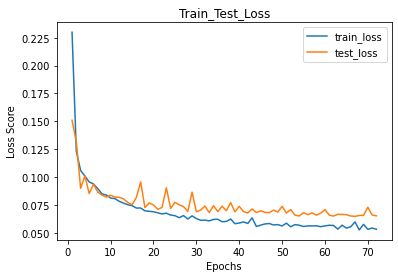

73
Train Epoch: 73 [0/7471 (0%)]	Loss: 0.050489
Train Epoch: 73 [160/7471 (2%)]	Loss: 0.057101
Train Epoch: 73 [320/7471 (4%)]	Loss: 0.057009
Train Epoch: 73 [480/7471 (6%)]	Loss: 0.052113
Train Epoch: 73 [640/7471 (9%)]	Loss: 0.074424
Train Epoch: 73 [800/7471 (11%)]	Loss: 0.057661
Train Epoch: 73 [960/7471 (13%)]	Loss: 0.069864
Train Epoch: 73 [1120/7471 (15%)]	Loss: 0.051009
Train Epoch: 73 [1280/7471 (17%)]	Loss: 0.053762
Train Epoch: 73 [1440/7471 (19%)]	Loss: 0.049775
Train Epoch: 73 [1600/7471 (21%)]	Loss: 0.051924
Train Epoch: 73 [1760/7471 (24%)]	Loss: 0.059793
Train Epoch: 73 [1920/7471 (26%)]	Loss: 0.052321
Train Epoch: 73 [2080/7471 (28%)]	Loss: 0.052367
Train Epoch: 73 [2240/7471 (30%)]	Loss: 0.049431
Train Epoch: 73 [2400/7471 (32%)]	Loss: 0.057735
Train Epoch: 73 [2560/7471 (34%)]	Loss: 0.059248
Train Epoch: 73 [2720/7471 (36%)]	Loss: 0.050839
Train Epoch: 73 [2880/7471 (39%)]	Loss: 0.083822
Train Epoch: 73 [3040/7471 (41%)]	Loss: 0.060760
Train Epoch: 73 [3200/7471 (43%

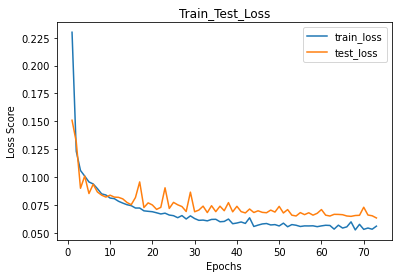

74
Train Epoch: 74 [0/7471 (0%)]	Loss: 0.048229
Train Epoch: 74 [160/7471 (2%)]	Loss: 0.049434
Train Epoch: 74 [320/7471 (4%)]	Loss: 0.047753
Train Epoch: 74 [480/7471 (6%)]	Loss: 0.049063
Train Epoch: 74 [640/7471 (9%)]	Loss: 0.050870
Train Epoch: 74 [800/7471 (11%)]	Loss: 0.050129
Train Epoch: 74 [960/7471 (13%)]	Loss: 0.048948
Train Epoch: 74 [1120/7471 (15%)]	Loss: 0.050486
Train Epoch: 74 [1280/7471 (17%)]	Loss: 0.051744
Train Epoch: 74 [1440/7471 (19%)]	Loss: 0.054674
Train Epoch: 74 [1600/7471 (21%)]	Loss: 0.055572
Train Epoch: 74 [1760/7471 (24%)]	Loss: 0.066788
Train Epoch: 74 [1920/7471 (26%)]	Loss: 0.050099
Train Epoch: 74 [2080/7471 (28%)]	Loss: 0.051270
Train Epoch: 74 [2240/7471 (30%)]	Loss: 0.053590
Train Epoch: 74 [2400/7471 (32%)]	Loss: 0.051418
Train Epoch: 74 [2560/7471 (34%)]	Loss: 0.050285
Train Epoch: 74 [2720/7471 (36%)]	Loss: 0.050563
Train Epoch: 74 [2880/7471 (39%)]	Loss: 0.055238
Train Epoch: 74 [3040/7471 (41%)]	Loss: 0.081011
Train Epoch: 74 [3200/7471 (43%

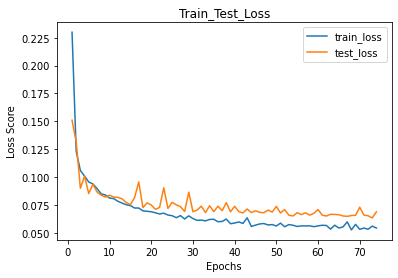

75
Train Epoch: 75 [0/7471 (0%)]	Loss: 0.054414
Train Epoch: 75 [160/7471 (2%)]	Loss: 0.050772
Train Epoch: 75 [320/7471 (4%)]	Loss: 0.058728
Train Epoch: 75 [480/7471 (6%)]	Loss: 0.053268
Train Epoch: 75 [640/7471 (9%)]	Loss: 0.055885
Train Epoch: 75 [800/7471 (11%)]	Loss: 0.061097
Train Epoch: 75 [960/7471 (13%)]	Loss: 0.065332
Train Epoch: 75 [1120/7471 (15%)]	Loss: 0.052521
Train Epoch: 75 [1280/7471 (17%)]	Loss: 0.049029
Train Epoch: 75 [1440/7471 (19%)]	Loss: 0.051487
Train Epoch: 75 [1600/7471 (21%)]	Loss: 0.049440
Train Epoch: 75 [1760/7471 (24%)]	Loss: 0.050528
Train Epoch: 75 [1920/7471 (26%)]	Loss: 0.055540
Train Epoch: 75 [2080/7471 (28%)]	Loss: 0.051198
Train Epoch: 75 [2240/7471 (30%)]	Loss: 0.055216
Train Epoch: 75 [2400/7471 (32%)]	Loss: 0.055788
Train Epoch: 75 [2560/7471 (34%)]	Loss: 0.051721
Train Epoch: 75 [2720/7471 (36%)]	Loss: 0.052311
Train Epoch: 75 [2880/7471 (39%)]	Loss: 0.049551
Train Epoch: 75 [3040/7471 (41%)]	Loss: 0.050899
Train Epoch: 75 [3200/7471 (43%

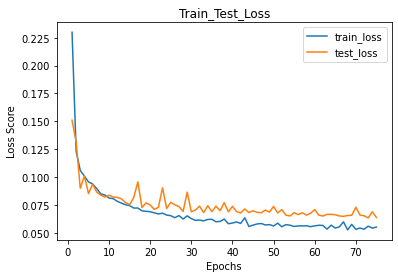

76
Train Epoch: 76 [0/7471 (0%)]	Loss: 0.048927
Train Epoch: 76 [160/7471 (2%)]	Loss: 0.049105
Train Epoch: 76 [320/7471 (4%)]	Loss: 0.056499
Train Epoch: 76 [480/7471 (6%)]	Loss: 0.050365
Train Epoch: 76 [640/7471 (9%)]	Loss: 0.062423
Train Epoch: 76 [800/7471 (11%)]	Loss: 0.054496
Train Epoch: 76 [960/7471 (13%)]	Loss: 0.069002
Train Epoch: 76 [1120/7471 (15%)]	Loss: 0.053313
Train Epoch: 76 [1280/7471 (17%)]	Loss: 0.053567
Train Epoch: 76 [1440/7471 (19%)]	Loss: 0.054996
Train Epoch: 76 [1600/7471 (21%)]	Loss: 0.052119
Train Epoch: 76 [1760/7471 (24%)]	Loss: 0.055396
Train Epoch: 76 [1920/7471 (26%)]	Loss: 0.050487
Train Epoch: 76 [2080/7471 (28%)]	Loss: 0.048433
Train Epoch: 76 [2240/7471 (30%)]	Loss: 0.051733
Train Epoch: 76 [2400/7471 (32%)]	Loss: 0.056591
Train Epoch: 76 [2560/7471 (34%)]	Loss: 0.052420
Train Epoch: 76 [2720/7471 (36%)]	Loss: 0.050243
Train Epoch: 76 [2880/7471 (39%)]	Loss: 0.052941
Train Epoch: 76 [3040/7471 (41%)]	Loss: 0.050013
Train Epoch: 76 [3200/7471 (43%

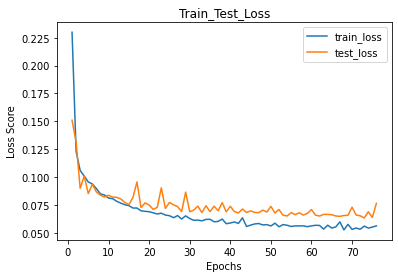

77
Train Epoch: 77 [0/7471 (0%)]	Loss: 0.064603
Train Epoch: 77 [160/7471 (2%)]	Loss: 0.052370
Train Epoch: 77 [320/7471 (4%)]	Loss: 0.050879
Train Epoch: 77 [480/7471 (6%)]	Loss: 0.082535
Train Epoch: 77 [640/7471 (9%)]	Loss: 0.056731
Train Epoch: 77 [800/7471 (11%)]	Loss: 0.065478
Train Epoch: 77 [960/7471 (13%)]	Loss: 0.058149
Train Epoch: 77 [1120/7471 (15%)]	Loss: 0.049759
Train Epoch: 77 [1280/7471 (17%)]	Loss: 0.050629
Train Epoch: 77 [1440/7471 (19%)]	Loss: 0.050885
Train Epoch: 77 [1600/7471 (21%)]	Loss: 0.052403
Train Epoch: 77 [1760/7471 (24%)]	Loss: 0.051603
Train Epoch: 77 [1920/7471 (26%)]	Loss: 0.053148
Train Epoch: 77 [2080/7471 (28%)]	Loss: 0.049998
Train Epoch: 77 [2240/7471 (30%)]	Loss: 0.049638
Train Epoch: 77 [2400/7471 (32%)]	Loss: 0.050860
Train Epoch: 77 [2560/7471 (34%)]	Loss: 0.050096
Train Epoch: 77 [2720/7471 (36%)]	Loss: 0.056741
Train Epoch: 77 [2880/7471 (39%)]	Loss: 0.050354
Train Epoch: 77 [3040/7471 (41%)]	Loss: 0.052608
Train Epoch: 77 [3200/7471 (43%

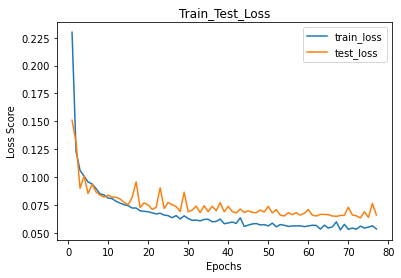

78
Train Epoch: 78 [0/7471 (0%)]	Loss: 0.050600
Train Epoch: 78 [160/7471 (2%)]	Loss: 0.058649
Train Epoch: 78 [320/7471 (4%)]	Loss: 0.054964
Train Epoch: 78 [480/7471 (6%)]	Loss: 0.049754
Train Epoch: 78 [640/7471 (9%)]	Loss: 0.048581
Train Epoch: 78 [800/7471 (11%)]	Loss: 0.049968
Train Epoch: 78 [960/7471 (13%)]	Loss: 0.050942
Train Epoch: 78 [1120/7471 (15%)]	Loss: 0.048241
Train Epoch: 78 [1280/7471 (17%)]	Loss: 0.050532
Train Epoch: 78 [1440/7471 (19%)]	Loss: 0.053051
Train Epoch: 78 [1600/7471 (21%)]	Loss: 0.057199
Train Epoch: 78 [1760/7471 (24%)]	Loss: 0.051443
Train Epoch: 78 [1920/7471 (26%)]	Loss: 0.057373
Train Epoch: 78 [2080/7471 (28%)]	Loss: 0.056878
Train Epoch: 78 [2240/7471 (30%)]	Loss: 0.052726
Train Epoch: 78 [2400/7471 (32%)]	Loss: 0.056164
Train Epoch: 78 [2560/7471 (34%)]	Loss: 0.096963
Train Epoch: 78 [2720/7471 (36%)]	Loss: 0.059823
Train Epoch: 78 [2880/7471 (39%)]	Loss: 0.055362
Train Epoch: 78 [3040/7471 (41%)]	Loss: 0.050461
Train Epoch: 78 [3200/7471 (43%

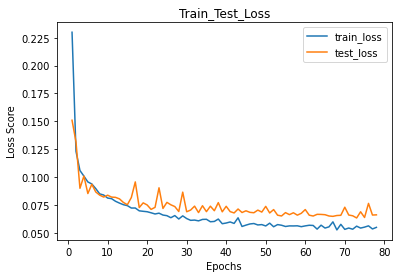

79
Train Epoch: 79 [0/7471 (0%)]	Loss: 0.051714
Train Epoch: 79 [160/7471 (2%)]	Loss: 0.059758
Train Epoch: 79 [320/7471 (4%)]	Loss: 0.048353
Train Epoch: 79 [480/7471 (6%)]	Loss: 0.051167
Train Epoch: 79 [640/7471 (9%)]	Loss: 0.050176
Train Epoch: 79 [800/7471 (11%)]	Loss: 0.050373
Train Epoch: 79 [960/7471 (13%)]	Loss: 0.057201
Train Epoch: 79 [1120/7471 (15%)]	Loss: 0.053294
Train Epoch: 79 [1280/7471 (17%)]	Loss: 0.048952
Train Epoch: 79 [1440/7471 (19%)]	Loss: 0.048629
Train Epoch: 79 [1600/7471 (21%)]	Loss: 0.054194
Train Epoch: 79 [1760/7471 (24%)]	Loss: 0.050359
Train Epoch: 79 [1920/7471 (26%)]	Loss: 0.050930
Train Epoch: 79 [2080/7471 (28%)]	Loss: 0.048711
Train Epoch: 79 [2240/7471 (30%)]	Loss: 0.079488
Train Epoch: 79 [2400/7471 (32%)]	Loss: 0.057442
Train Epoch: 79 [2560/7471 (34%)]	Loss: 0.058687
Train Epoch: 79 [2720/7471 (36%)]	Loss: 0.053140
Train Epoch: 79 [2880/7471 (39%)]	Loss: 0.055369
Train Epoch: 79 [3040/7471 (41%)]	Loss: 0.064851
Train Epoch: 79 [3200/7471 (43%

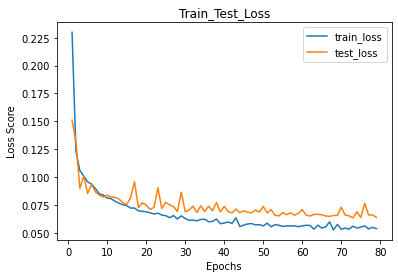

80
Train Epoch: 80 [0/7471 (0%)]	Loss: 0.049569
Train Epoch: 80 [160/7471 (2%)]	Loss: 0.056000
Train Epoch: 80 [320/7471 (4%)]	Loss: 0.050099
Train Epoch: 80 [480/7471 (6%)]	Loss: 0.049913
Train Epoch: 80 [640/7471 (9%)]	Loss: 0.047973
Train Epoch: 80 [800/7471 (11%)]	Loss: 0.049686
Train Epoch: 80 [960/7471 (13%)]	Loss: 0.056556
Train Epoch: 80 [1120/7471 (15%)]	Loss: 0.065035
Train Epoch: 80 [1280/7471 (17%)]	Loss: 0.051536
Train Epoch: 80 [1440/7471 (19%)]	Loss: 0.053650
Train Epoch: 80 [1600/7471 (21%)]	Loss: 0.055423
Train Epoch: 80 [1760/7471 (24%)]	Loss: 0.050306
Train Epoch: 80 [1920/7471 (26%)]	Loss: 0.049461
Train Epoch: 80 [2080/7471 (28%)]	Loss: 0.051443
Train Epoch: 80 [2240/7471 (30%)]	Loss: 0.062431
Train Epoch: 80 [2400/7471 (32%)]	Loss: 0.053782
Train Epoch: 80 [2560/7471 (34%)]	Loss: 0.053799
Train Epoch: 80 [2720/7471 (36%)]	Loss: 0.066236
Train Epoch: 80 [2880/7471 (39%)]	Loss: 0.063935
Train Epoch: 80 [3040/7471 (41%)]	Loss: 0.062512
Train Epoch: 80 [3200/7471 (43%

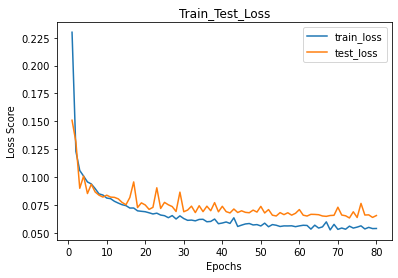

81
Train Epoch: 81 [0/7471 (0%)]	Loss: 0.050695
Train Epoch: 81 [160/7471 (2%)]	Loss: 0.051765
Train Epoch: 81 [320/7471 (4%)]	Loss: 0.054124
Train Epoch: 81 [480/7471 (6%)]	Loss: 0.058467
Train Epoch: 81 [640/7471 (9%)]	Loss: 0.051494
Train Epoch: 81 [800/7471 (11%)]	Loss: 0.051298
Train Epoch: 81 [960/7471 (13%)]	Loss: 0.053862
Train Epoch: 81 [1120/7471 (15%)]	Loss: 0.049450
Train Epoch: 81 [1280/7471 (17%)]	Loss: 0.050024
Train Epoch: 81 [1440/7471 (19%)]	Loss: 0.067882
Train Epoch: 81 [1600/7471 (21%)]	Loss: 0.049191
Train Epoch: 81 [1760/7471 (24%)]	Loss: 0.087585
Train Epoch: 81 [1920/7471 (26%)]	Loss: 0.050954
Train Epoch: 81 [2080/7471 (28%)]	Loss: 0.049059
Train Epoch: 81 [2240/7471 (30%)]	Loss: 0.052385
Train Epoch: 81 [2400/7471 (32%)]	Loss: 0.049381
Train Epoch: 81 [2560/7471 (34%)]	Loss: 0.048093
Train Epoch: 81 [2720/7471 (36%)]	Loss: 0.050616
Train Epoch: 81 [2880/7471 (39%)]	Loss: 0.047987
Train Epoch: 81 [3040/7471 (41%)]	Loss: 0.067061
Train Epoch: 81 [3200/7471 (43%

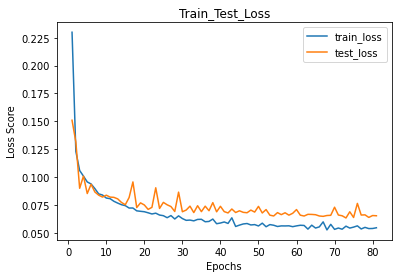

82
Train Epoch: 82 [0/7471 (0%)]	Loss: 0.051441
Train Epoch: 82 [160/7471 (2%)]	Loss: 0.049314
Train Epoch: 82 [320/7471 (4%)]	Loss: 0.051983
Train Epoch: 82 [480/7471 (6%)]	Loss: 0.051120
Train Epoch: 82 [640/7471 (9%)]	Loss: 0.054780
Train Epoch: 82 [800/7471 (11%)]	Loss: 0.065509
Train Epoch: 82 [960/7471 (13%)]	Loss: 0.051840
Train Epoch: 82 [1120/7471 (15%)]	Loss: 0.049754
Train Epoch: 82 [1280/7471 (17%)]	Loss: 0.049089
Train Epoch: 82 [1440/7471 (19%)]	Loss: 0.062889
Train Epoch: 82 [1600/7471 (21%)]	Loss: 0.052153
Train Epoch: 82 [1760/7471 (24%)]	Loss: 0.053961
Train Epoch: 82 [1920/7471 (26%)]	Loss: 0.055454
Train Epoch: 82 [2080/7471 (28%)]	Loss: 0.056727
Train Epoch: 82 [2240/7471 (30%)]	Loss: 0.060249
Train Epoch: 82 [2400/7471 (32%)]	Loss: 0.050634
Train Epoch: 82 [2560/7471 (34%)]	Loss: 0.060731
Train Epoch: 82 [2720/7471 (36%)]	Loss: 0.069206
Train Epoch: 82 [2880/7471 (39%)]	Loss: 0.049189
Train Epoch: 82 [3040/7471 (41%)]	Loss: 0.047872
Train Epoch: 82 [3200/7471 (43%

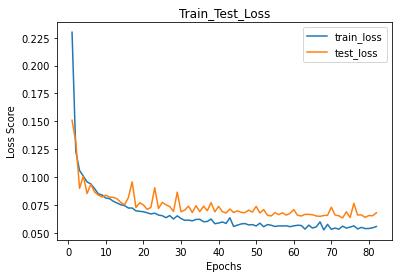

83
Train Epoch: 83 [0/7471 (0%)]	Loss: 0.053006
Train Epoch: 83 [160/7471 (2%)]	Loss: 0.068804
Train Epoch: 83 [320/7471 (4%)]	Loss: 0.137657
Train Epoch: 83 [480/7471 (6%)]	Loss: 0.073845
Train Epoch: 83 [640/7471 (9%)]	Loss: 0.059529
Train Epoch: 83 [800/7471 (11%)]	Loss: 0.052277
Train Epoch: 83 [960/7471 (13%)]	Loss: 0.049713
Train Epoch: 83 [1120/7471 (15%)]	Loss: 0.053714
Train Epoch: 83 [1280/7471 (17%)]	Loss: 0.054704
Train Epoch: 83 [1440/7471 (19%)]	Loss: 0.069608
Train Epoch: 83 [1600/7471 (21%)]	Loss: 0.072530
Train Epoch: 83 [1760/7471 (24%)]	Loss: 0.052457
Train Epoch: 83 [1920/7471 (26%)]	Loss: 0.055158
Train Epoch: 83 [2080/7471 (28%)]	Loss: 0.049631
Train Epoch: 83 [2240/7471 (30%)]	Loss: 0.047739
Train Epoch: 83 [2400/7471 (32%)]	Loss: 0.048754
Train Epoch: 83 [2560/7471 (34%)]	Loss: 0.052350
Train Epoch: 83 [2720/7471 (36%)]	Loss: 0.047860
Train Epoch: 83 [2880/7471 (39%)]	Loss: 0.048290
Train Epoch: 83 [3040/7471 (41%)]	Loss: 0.049014
Train Epoch: 83 [3200/7471 (43%

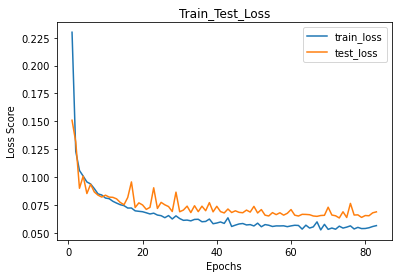

84
Train Epoch: 84 [0/7471 (0%)]	Loss: 0.055151
Train Epoch: 84 [160/7471 (2%)]	Loss: 0.049886
Train Epoch: 84 [320/7471 (4%)]	Loss: 0.049695
Train Epoch: 84 [480/7471 (6%)]	Loss: 0.057802
Train Epoch: 84 [640/7471 (9%)]	Loss: 0.049747
Train Epoch: 84 [800/7471 (11%)]	Loss: 0.049917
Train Epoch: 84 [960/7471 (13%)]	Loss: 0.049442
Train Epoch: 84 [1120/7471 (15%)]	Loss: 0.048408
Train Epoch: 84 [1280/7471 (17%)]	Loss: 0.048422
Train Epoch: 84 [1440/7471 (19%)]	Loss: 0.051958
Train Epoch: 84 [1600/7471 (21%)]	Loss: 0.051255
Train Epoch: 84 [1760/7471 (24%)]	Loss: 0.050144
Train Epoch: 84 [1920/7471 (26%)]	Loss: 0.052289
Train Epoch: 84 [2080/7471 (28%)]	Loss: 0.048258
Train Epoch: 84 [2240/7471 (30%)]	Loss: 0.048863
Train Epoch: 84 [2400/7471 (32%)]	Loss: 0.050434
Train Epoch: 84 [2560/7471 (34%)]	Loss: 0.050516
Train Epoch: 84 [2720/7471 (36%)]	Loss: 0.048428
Train Epoch: 84 [2880/7471 (39%)]	Loss: 0.052796
Train Epoch: 84 [3040/7471 (41%)]	Loss: 0.049463
Train Epoch: 84 [3200/7471 (43%

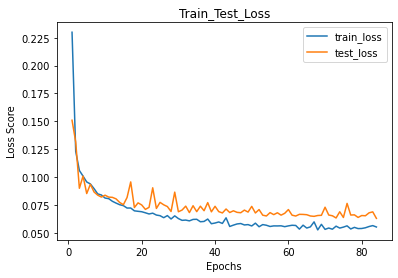

85
Train Epoch: 85 [0/7471 (0%)]	Loss: 0.048234
Train Epoch: 85 [160/7471 (2%)]	Loss: 0.049345
Train Epoch: 85 [320/7471 (4%)]	Loss: 0.049161
Train Epoch: 85 [480/7471 (6%)]	Loss: 0.048781
Train Epoch: 85 [640/7471 (9%)]	Loss: 0.048318
Train Epoch: 85 [800/7471 (11%)]	Loss: 0.050881
Train Epoch: 85 [960/7471 (13%)]	Loss: 0.051154
Train Epoch: 85 [1120/7471 (15%)]	Loss: 0.048953
Train Epoch: 85 [1280/7471 (17%)]	Loss: 0.056471
Train Epoch: 85 [1440/7471 (19%)]	Loss: 0.051256
Train Epoch: 85 [1600/7471 (21%)]	Loss: 0.047421
Train Epoch: 85 [1760/7471 (24%)]	Loss: 0.049605
Train Epoch: 85 [1920/7471 (26%)]	Loss: 0.052272
Train Epoch: 85 [2080/7471 (28%)]	Loss: 0.049863
Train Epoch: 85 [2240/7471 (30%)]	Loss: 0.048602
Train Epoch: 85 [2400/7471 (32%)]	Loss: 0.051988
Train Epoch: 85 [2560/7471 (34%)]	Loss: 0.051039
Train Epoch: 85 [2720/7471 (36%)]	Loss: 0.052422
Train Epoch: 85 [2880/7471 (39%)]	Loss: 0.049596
Train Epoch: 85 [3040/7471 (41%)]	Loss: 0.049556
Train Epoch: 85 [3200/7471 (43%

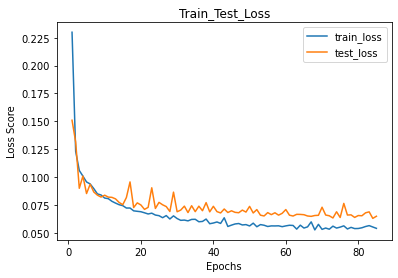

86
Train Epoch: 86 [0/7471 (0%)]	Loss: 0.049990
Train Epoch: 86 [160/7471 (2%)]	Loss: 0.061876
Train Epoch: 86 [320/7471 (4%)]	Loss: 0.073202
Train Epoch: 86 [480/7471 (6%)]	Loss: 0.063411
Train Epoch: 86 [640/7471 (9%)]	Loss: 0.054087
Train Epoch: 86 [800/7471 (11%)]	Loss: 0.067668
Train Epoch: 86 [960/7471 (13%)]	Loss: 0.057596
Train Epoch: 86 [1120/7471 (15%)]	Loss: 0.049843
Train Epoch: 86 [1280/7471 (17%)]	Loss: 0.050215
Train Epoch: 86 [1440/7471 (19%)]	Loss: 0.048064
Train Epoch: 86 [1600/7471 (21%)]	Loss: 0.051433
Train Epoch: 86 [1760/7471 (24%)]	Loss: 0.048878
Train Epoch: 86 [1920/7471 (26%)]	Loss: 0.049109
Train Epoch: 86 [2080/7471 (28%)]	Loss: 0.049487
Train Epoch: 86 [2240/7471 (30%)]	Loss: 0.060811
Train Epoch: 86 [2400/7471 (32%)]	Loss: 0.054098
Train Epoch: 86 [2560/7471 (34%)]	Loss: 0.053897
Train Epoch: 86 [2720/7471 (36%)]	Loss: 0.052178
Train Epoch: 86 [2880/7471 (39%)]	Loss: 0.047978
Train Epoch: 86 [3040/7471 (41%)]	Loss: 0.071524
Train Epoch: 86 [3200/7471 (43%

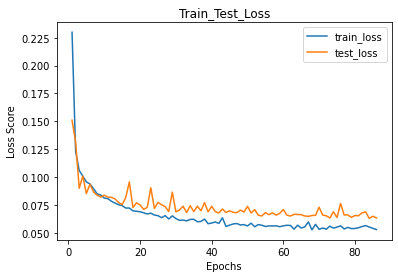

87
Train Epoch: 87 [0/7471 (0%)]	Loss: 0.046907
Train Epoch: 87 [160/7471 (2%)]	Loss: 0.049472
Train Epoch: 87 [320/7471 (4%)]	Loss: 0.049998
Train Epoch: 87 [480/7471 (6%)]	Loss: 0.048720
Train Epoch: 87 [640/7471 (9%)]	Loss: 0.050190
Train Epoch: 87 [800/7471 (11%)]	Loss: 0.048164
Train Epoch: 87 [960/7471 (13%)]	Loss: 0.052820
Train Epoch: 87 [1120/7471 (15%)]	Loss: 0.050152
Train Epoch: 87 [1280/7471 (17%)]	Loss: 0.049643
Train Epoch: 87 [1440/7471 (19%)]	Loss: 0.048155
Train Epoch: 87 [1600/7471 (21%)]	Loss: 0.048704
Train Epoch: 87 [1760/7471 (24%)]	Loss: 0.051310
Train Epoch: 87 [1920/7471 (26%)]	Loss: 0.049588
Train Epoch: 87 [2080/7471 (28%)]	Loss: 0.049162
Train Epoch: 87 [2240/7471 (30%)]	Loss: 0.052721
Train Epoch: 87 [2400/7471 (32%)]	Loss: 0.053126
Train Epoch: 87 [2560/7471 (34%)]	Loss: 0.048245
Train Epoch: 87 [2720/7471 (36%)]	Loss: 0.048360
Train Epoch: 87 [2880/7471 (39%)]	Loss: 0.054940
Train Epoch: 87 [3040/7471 (41%)]	Loss: 0.051534
Train Epoch: 87 [3200/7471 (43%

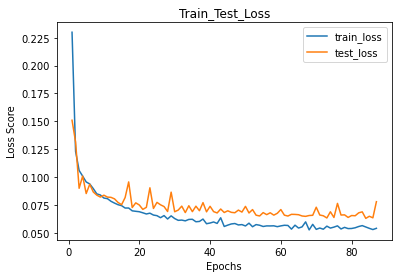

88
Train Epoch: 88 [0/7471 (0%)]	Loss: 0.060649
Train Epoch: 88 [160/7471 (2%)]	Loss: 0.054758
Train Epoch: 88 [320/7471 (4%)]	Loss: 0.051013
Train Epoch: 88 [480/7471 (6%)]	Loss: 0.055736
Train Epoch: 88 [640/7471 (9%)]	Loss: 0.083974
Train Epoch: 88 [800/7471 (11%)]	Loss: 0.058222
Train Epoch: 88 [960/7471 (13%)]	Loss: 0.053664
Train Epoch: 88 [1120/7471 (15%)]	Loss: 0.050243
Train Epoch: 88 [1280/7471 (17%)]	Loss: 0.057769
Train Epoch: 88 [1440/7471 (19%)]	Loss: 0.051671
Train Epoch: 88 [1600/7471 (21%)]	Loss: 0.050603
Train Epoch: 88 [1760/7471 (24%)]	Loss: 0.050306
Train Epoch: 88 [1920/7471 (26%)]	Loss: 0.047935
Train Epoch: 88 [2080/7471 (28%)]	Loss: 0.047479
Train Epoch: 88 [2240/7471 (30%)]	Loss: 0.049204
Train Epoch: 88 [2400/7471 (32%)]	Loss: 0.048993
Train Epoch: 88 [2560/7471 (34%)]	Loss: 0.048447
Train Epoch: 88 [2720/7471 (36%)]	Loss: 0.054162
Train Epoch: 88 [2880/7471 (39%)]	Loss: 0.052037
Train Epoch: 88 [3040/7471 (41%)]	Loss: 0.049383
Train Epoch: 88 [3200/7471 (43%

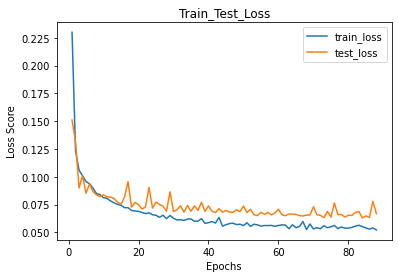

89
Train Epoch: 89 [0/7471 (0%)]	Loss: 0.050719
Train Epoch: 89 [160/7471 (2%)]	Loss: 0.054933
Train Epoch: 89 [320/7471 (4%)]	Loss: 0.069937
Train Epoch: 89 [480/7471 (6%)]	Loss: 0.049319
Train Epoch: 89 [640/7471 (9%)]	Loss: 0.066590
Train Epoch: 89 [800/7471 (11%)]	Loss: 0.051071
Train Epoch: 89 [960/7471 (13%)]	Loss: 0.069284
Train Epoch: 89 [1120/7471 (15%)]	Loss: 0.075751
Train Epoch: 89 [1280/7471 (17%)]	Loss: 0.053360
Train Epoch: 89 [1440/7471 (19%)]	Loss: 0.049273
Train Epoch: 89 [1600/7471 (21%)]	Loss: 0.056922
Train Epoch: 89 [1760/7471 (24%)]	Loss: 0.054843
Train Epoch: 89 [1920/7471 (26%)]	Loss: 0.050294
Train Epoch: 89 [2080/7471 (28%)]	Loss: 0.050570
Train Epoch: 89 [2240/7471 (30%)]	Loss: 0.050485
Train Epoch: 89 [2400/7471 (32%)]	Loss: 0.048701
Train Epoch: 89 [2560/7471 (34%)]	Loss: 0.048534
Train Epoch: 89 [2720/7471 (36%)]	Loss: 0.054924
Train Epoch: 89 [2880/7471 (39%)]	Loss: 0.055234
Train Epoch: 89 [3040/7471 (41%)]	Loss: 0.049439
Train Epoch: 89 [3200/7471 (43%

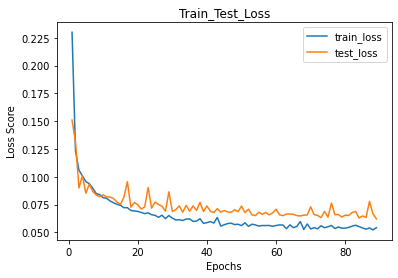

90
Train Epoch: 90 [0/7471 (0%)]	Loss: 0.047940
Train Epoch: 90 [160/7471 (2%)]	Loss: 0.055080
Train Epoch: 90 [320/7471 (4%)]	Loss: 0.054890
Train Epoch: 90 [480/7471 (6%)]	Loss: 0.051007
Train Epoch: 90 [640/7471 (9%)]	Loss: 0.053624
Train Epoch: 90 [800/7471 (11%)]	Loss: 0.053199
Train Epoch: 90 [960/7471 (13%)]	Loss: 0.051077
Train Epoch: 90 [1120/7471 (15%)]	Loss: 0.050183
Train Epoch: 90 [1280/7471 (17%)]	Loss: 0.047966
Train Epoch: 90 [1440/7471 (19%)]	Loss: 0.053417
Train Epoch: 90 [1600/7471 (21%)]	Loss: 0.054307
Train Epoch: 90 [1760/7471 (24%)]	Loss: 0.057444
Train Epoch: 90 [1920/7471 (26%)]	Loss: 0.062601
Train Epoch: 90 [2080/7471 (28%)]	Loss: 0.053042
Train Epoch: 90 [2240/7471 (30%)]	Loss: 0.059408
Train Epoch: 90 [2400/7471 (32%)]	Loss: 0.055814
Train Epoch: 90 [2560/7471 (34%)]	Loss: 0.051477
Train Epoch: 90 [2720/7471 (36%)]	Loss: 0.051310
Train Epoch: 90 [2880/7471 (39%)]	Loss: 0.055780
Train Epoch: 90 [3040/7471 (41%)]	Loss: 0.054162
Train Epoch: 90 [3200/7471 (43%

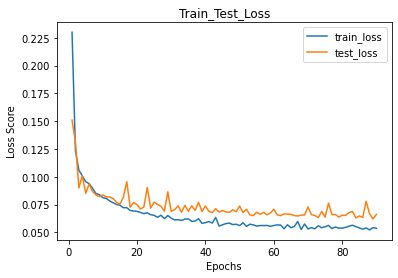

91
Train Epoch: 91 [0/7471 (0%)]	Loss: 0.052238
Train Epoch: 91 [160/7471 (2%)]	Loss: 0.051681
Train Epoch: 91 [320/7471 (4%)]	Loss: 0.048563
Train Epoch: 91 [480/7471 (6%)]	Loss: 0.050814
Train Epoch: 91 [640/7471 (9%)]	Loss: 0.057527
Train Epoch: 91 [800/7471 (11%)]	Loss: 0.054071
Train Epoch: 91 [960/7471 (13%)]	Loss: 0.057996
Train Epoch: 91 [1120/7471 (15%)]	Loss: 0.048616
Train Epoch: 91 [1280/7471 (17%)]	Loss: 0.050292
Train Epoch: 91 [1440/7471 (19%)]	Loss: 0.052086
Train Epoch: 91 [1600/7471 (21%)]	Loss: 0.049091
Train Epoch: 91 [1760/7471 (24%)]	Loss: 0.048344
Train Epoch: 91 [1920/7471 (26%)]	Loss: 0.048327
Train Epoch: 91 [2080/7471 (28%)]	Loss: 0.048858
Train Epoch: 91 [2240/7471 (30%)]	Loss: 0.048370
Train Epoch: 91 [2400/7471 (32%)]	Loss: 0.048028
Train Epoch: 91 [2560/7471 (34%)]	Loss: 0.049011
Train Epoch: 91 [2720/7471 (36%)]	Loss: 0.048694
Train Epoch: 91 [2880/7471 (39%)]	Loss: 0.066192
Train Epoch: 91 [3040/7471 (41%)]	Loss: 0.052212
Train Epoch: 91 [3200/7471 (43%

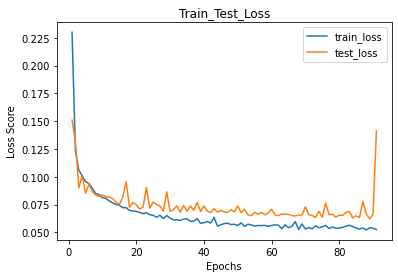

92
Train Epoch: 92 [0/7471 (0%)]	Loss: 0.118775
Train Epoch: 92 [160/7471 (2%)]	Loss: 0.054623
Train Epoch: 92 [320/7471 (4%)]	Loss: 0.095947
Train Epoch: 92 [480/7471 (6%)]	Loss: 0.121390
Train Epoch: 92 [640/7471 (9%)]	Loss: 0.137382
Train Epoch: 92 [800/7471 (11%)]	Loss: 0.056331
Train Epoch: 92 [960/7471 (13%)]	Loss: 0.056961
Train Epoch: 92 [1120/7471 (15%)]	Loss: 0.050302
Train Epoch: 92 [1280/7471 (17%)]	Loss: 0.054623
Train Epoch: 92 [1440/7471 (19%)]	Loss: 0.056045
Train Epoch: 92 [1600/7471 (21%)]	Loss: 0.052361
Train Epoch: 92 [1760/7471 (24%)]	Loss: 0.048059
Train Epoch: 92 [1920/7471 (26%)]	Loss: 0.048878
Train Epoch: 92 [2080/7471 (28%)]	Loss: 0.048626
Train Epoch: 92 [2240/7471 (30%)]	Loss: 0.049058
Train Epoch: 92 [2400/7471 (32%)]	Loss: 0.048039
Train Epoch: 92 [2560/7471 (34%)]	Loss: 0.048690
Train Epoch: 92 [2720/7471 (36%)]	Loss: 0.049935
Train Epoch: 92 [2880/7471 (39%)]	Loss: 0.047708
Train Epoch: 92 [3040/7471 (41%)]	Loss: 0.046599
Train Epoch: 92 [3200/7471 (43%

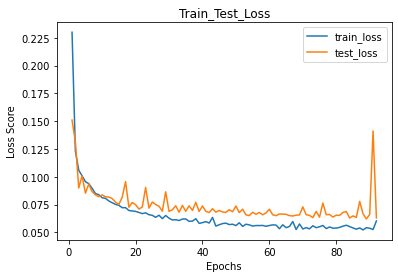

93
Train Epoch: 93 [0/7471 (0%)]	Loss: 0.049183
Train Epoch: 93 [160/7471 (2%)]	Loss: 0.050548
Train Epoch: 93 [320/7471 (4%)]	Loss: 0.049156
Train Epoch: 93 [480/7471 (6%)]	Loss: 0.049313
Train Epoch: 93 [640/7471 (9%)]	Loss: 0.048002
Train Epoch: 93 [800/7471 (11%)]	Loss: 0.047806
Train Epoch: 93 [960/7471 (13%)]	Loss: 0.048324
Train Epoch: 93 [1120/7471 (15%)]	Loss: 0.052738
Train Epoch: 93 [1280/7471 (17%)]	Loss: 0.050445
Train Epoch: 93 [1440/7471 (19%)]	Loss: 0.049086
Train Epoch: 93 [1600/7471 (21%)]	Loss: 0.048915
Train Epoch: 93 [1760/7471 (24%)]	Loss: 0.047814
Train Epoch: 93 [1920/7471 (26%)]	Loss: 0.048189
Train Epoch: 93 [2080/7471 (28%)]	Loss: 0.049829
Train Epoch: 93 [2240/7471 (30%)]	Loss: 0.050490
Train Epoch: 93 [2400/7471 (32%)]	Loss: 0.054732
Train Epoch: 93 [2560/7471 (34%)]	Loss: 0.047470
Train Epoch: 93 [2720/7471 (36%)]	Loss: 0.048486
Train Epoch: 93 [2880/7471 (39%)]	Loss: 0.049247
Train Epoch: 93 [3040/7471 (41%)]	Loss: 0.048297
Train Epoch: 93 [3200/7471 (43%

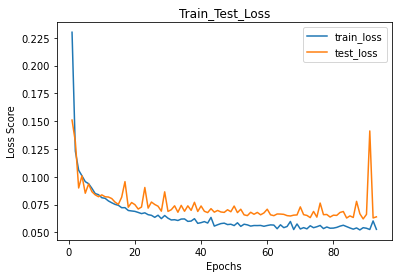

94
Train Epoch: 94 [0/7471 (0%)]	Loss: 0.048792
Train Epoch: 94 [160/7471 (2%)]	Loss: 0.047730
Train Epoch: 94 [320/7471 (4%)]	Loss: 0.049473
Train Epoch: 94 [480/7471 (6%)]	Loss: 0.049513
Train Epoch: 94 [640/7471 (9%)]	Loss: 0.047963
Train Epoch: 94 [800/7471 (11%)]	Loss: 0.047256
Train Epoch: 94 [960/7471 (13%)]	Loss: 0.047698
Train Epoch: 94 [1120/7471 (15%)]	Loss: 0.048082
Train Epoch: 94 [1280/7471 (17%)]	Loss: 0.047211
Train Epoch: 94 [1440/7471 (19%)]	Loss: 0.049249
Train Epoch: 94 [1600/7471 (21%)]	Loss: 0.050503
Train Epoch: 94 [1760/7471 (24%)]	Loss: 0.049560
Train Epoch: 94 [1920/7471 (26%)]	Loss: 0.049622
Train Epoch: 94 [2080/7471 (28%)]	Loss: 0.048975
Train Epoch: 94 [2240/7471 (30%)]	Loss: 0.050362
Train Epoch: 94 [2400/7471 (32%)]	Loss: 0.061363
Train Epoch: 94 [2560/7471 (34%)]	Loss: 0.063861
Train Epoch: 94 [2720/7471 (36%)]	Loss: 0.048503
Train Epoch: 94 [2880/7471 (39%)]	Loss: 0.056586
Train Epoch: 94 [3040/7471 (41%)]	Loss: 0.047603
Train Epoch: 94 [3200/7471 (43%

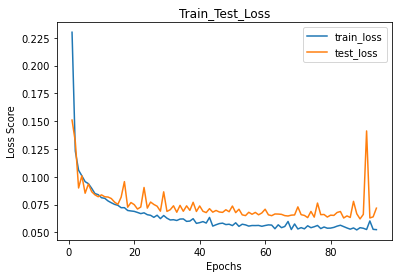

95
Train Epoch: 95 [0/7471 (0%)]	Loss: 0.057225
Train Epoch: 95 [160/7471 (2%)]	Loss: 0.061903
Train Epoch: 95 [320/7471 (4%)]	Loss: 0.049437
Train Epoch: 95 [480/7471 (6%)]	Loss: 0.047962
Train Epoch: 95 [640/7471 (9%)]	Loss: 0.047732
Train Epoch: 95 [800/7471 (11%)]	Loss: 0.048798
Train Epoch: 95 [960/7471 (13%)]	Loss: 0.060174
Train Epoch: 95 [1120/7471 (15%)]	Loss: 0.050151
Train Epoch: 95 [1280/7471 (17%)]	Loss: 0.054191
Train Epoch: 95 [1440/7471 (19%)]	Loss: 0.049030
Train Epoch: 95 [1600/7471 (21%)]	Loss: 0.052793
Train Epoch: 95 [1760/7471 (24%)]	Loss: 0.048840
Train Epoch: 95 [1920/7471 (26%)]	Loss: 0.051040
Train Epoch: 95 [2080/7471 (28%)]	Loss: 0.052848
Train Epoch: 95 [2240/7471 (30%)]	Loss: 0.051325
Train Epoch: 95 [2400/7471 (32%)]	Loss: 0.050295
Train Epoch: 95 [2560/7471 (34%)]	Loss: 0.049829
Train Epoch: 95 [2720/7471 (36%)]	Loss: 0.050252
Train Epoch: 95 [2880/7471 (39%)]	Loss: 0.054536
Train Epoch: 95 [3040/7471 (41%)]	Loss: 0.050514
Train Epoch: 95 [3200/7471 (43%

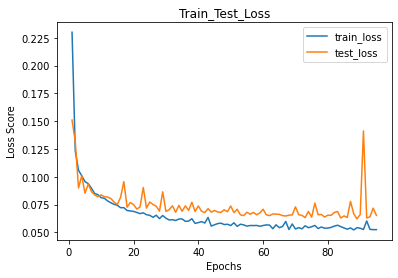

96
Train Epoch: 96 [0/7471 (0%)]	Loss: 0.051077
Train Epoch: 96 [160/7471 (2%)]	Loss: 0.047769
Train Epoch: 96 [320/7471 (4%)]	Loss: 0.052319
Train Epoch: 96 [480/7471 (6%)]	Loss: 0.050081
Train Epoch: 96 [640/7471 (9%)]	Loss: 0.049843
Train Epoch: 96 [800/7471 (11%)]	Loss: 0.048967
Train Epoch: 96 [960/7471 (13%)]	Loss: 0.047682
Train Epoch: 96 [1120/7471 (15%)]	Loss: 0.050510
Train Epoch: 96 [1280/7471 (17%)]	Loss: 0.051035
Train Epoch: 96 [1440/7471 (19%)]	Loss: 0.052099
Train Epoch: 96 [1600/7471 (21%)]	Loss: 0.048056
Train Epoch: 96 [1760/7471 (24%)]	Loss: 0.075984
Train Epoch: 96 [1920/7471 (26%)]	Loss: 0.053512
Train Epoch: 96 [2080/7471 (28%)]	Loss: 0.048330
Train Epoch: 96 [2240/7471 (30%)]	Loss: 0.048748
Train Epoch: 96 [2400/7471 (32%)]	Loss: 0.049577
Train Epoch: 96 [2560/7471 (34%)]	Loss: 0.048812
Train Epoch: 96 [2720/7471 (36%)]	Loss: 0.048812
Train Epoch: 96 [2880/7471 (39%)]	Loss: 0.051092
Train Epoch: 96 [3040/7471 (41%)]	Loss: 0.051330
Train Epoch: 96 [3200/7471 (43%

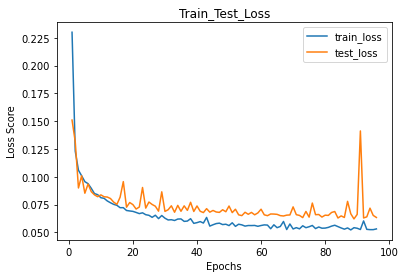

97
Train Epoch: 97 [0/7471 (0%)]	Loss: 0.048787
Train Epoch: 97 [160/7471 (2%)]	Loss: 0.053546
Train Epoch: 97 [320/7471 (4%)]	Loss: 0.051820
Train Epoch: 97 [480/7471 (6%)]	Loss: 0.053454
Train Epoch: 97 [640/7471 (9%)]	Loss: 0.078923
Train Epoch: 97 [800/7471 (11%)]	Loss: 0.065625
Train Epoch: 97 [960/7471 (13%)]	Loss: 0.111747
Train Epoch: 97 [1120/7471 (15%)]	Loss: 0.050979
Train Epoch: 97 [1280/7471 (17%)]	Loss: 0.075609
Train Epoch: 97 [1440/7471 (19%)]	Loss: 0.054406
Train Epoch: 97 [1600/7471 (21%)]	Loss: 0.054358
Train Epoch: 97 [1760/7471 (24%)]	Loss: 0.050130
Train Epoch: 97 [1920/7471 (26%)]	Loss: 0.054469
Train Epoch: 97 [2080/7471 (28%)]	Loss: 0.066245
Train Epoch: 97 [2240/7471 (30%)]	Loss: 0.049939
Train Epoch: 97 [2400/7471 (32%)]	Loss: 0.054155
Train Epoch: 97 [2560/7471 (34%)]	Loss: 0.049090
Train Epoch: 97 [2720/7471 (36%)]	Loss: 0.056538
Train Epoch: 97 [2880/7471 (39%)]	Loss: 0.051855
Train Epoch: 97 [3040/7471 (41%)]	Loss: 0.048702
Train Epoch: 97 [3200/7471 (43%

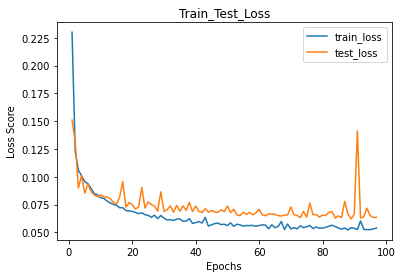

98
Train Epoch: 98 [0/7471 (0%)]	Loss: 0.048686
Train Epoch: 98 [160/7471 (2%)]	Loss: 0.061739
Train Epoch: 98 [320/7471 (4%)]	Loss: 0.050406
Train Epoch: 98 [480/7471 (6%)]	Loss: 0.053798
Train Epoch: 98 [640/7471 (9%)]	Loss: 0.056590
Train Epoch: 98 [800/7471 (11%)]	Loss: 0.050992
Train Epoch: 98 [960/7471 (13%)]	Loss: 0.077536
Train Epoch: 98 [1120/7471 (15%)]	Loss: 0.064016
Train Epoch: 98 [1280/7471 (17%)]	Loss: 0.053346
Train Epoch: 98 [1440/7471 (19%)]	Loss: 0.061427
Train Epoch: 98 [1600/7471 (21%)]	Loss: 0.052658
Train Epoch: 98 [1760/7471 (24%)]	Loss: 0.048325
Train Epoch: 98 [1920/7471 (26%)]	Loss: 0.061994
Train Epoch: 98 [2080/7471 (28%)]	Loss: 0.048598
Train Epoch: 98 [2240/7471 (30%)]	Loss: 0.050854
Train Epoch: 98 [2400/7471 (32%)]	Loss: 0.051164
Train Epoch: 98 [2560/7471 (34%)]	Loss: 0.055468
Train Epoch: 98 [2720/7471 (36%)]	Loss: 0.059541
Train Epoch: 98 [2880/7471 (39%)]	Loss: 0.052856
Train Epoch: 98 [3040/7471 (41%)]	Loss: 0.065254
Train Epoch: 98 [3200/7471 (43%

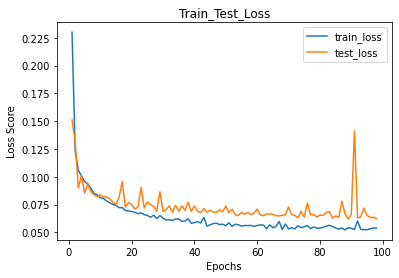

99
Train Epoch: 99 [0/7471 (0%)]	Loss: 0.048333
Train Epoch: 99 [160/7471 (2%)]	Loss: 0.051467
Train Epoch: 99 [320/7471 (4%)]	Loss: 0.057395
Train Epoch: 99 [480/7471 (6%)]	Loss: 0.050519
Train Epoch: 99 [640/7471 (9%)]	Loss: 0.051336
Train Epoch: 99 [800/7471 (11%)]	Loss: 0.046740
Train Epoch: 99 [960/7471 (13%)]	Loss: 0.050417
Train Epoch: 99 [1120/7471 (15%)]	Loss: 0.051322
Train Epoch: 99 [1280/7471 (17%)]	Loss: 0.047909
Train Epoch: 99 [1440/7471 (19%)]	Loss: 0.057633
Train Epoch: 99 [1600/7471 (21%)]	Loss: 0.047875
Train Epoch: 99 [1760/7471 (24%)]	Loss: 0.049906
Train Epoch: 99 [1920/7471 (26%)]	Loss: 0.053203
Train Epoch: 99 [2080/7471 (28%)]	Loss: 0.048530
Train Epoch: 99 [2240/7471 (30%)]	Loss: 0.049457
Train Epoch: 99 [2400/7471 (32%)]	Loss: 0.049207
Train Epoch: 99 [2560/7471 (34%)]	Loss: 0.048238
Train Epoch: 99 [2720/7471 (36%)]	Loss: 0.048363
Train Epoch: 99 [2880/7471 (39%)]	Loss: 0.050342
Train Epoch: 99 [3040/7471 (41%)]	Loss: 0.051186
Train Epoch: 99 [3200/7471 (43%

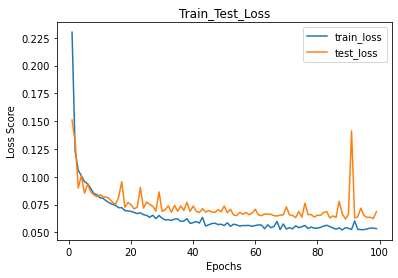

100
Train Epoch: 100 [0/7471 (0%)]	Loss: 0.053100
Train Epoch: 100 [160/7471 (2%)]	Loss: 0.049688
Train Epoch: 100 [320/7471 (4%)]	Loss: 0.047236
Train Epoch: 100 [480/7471 (6%)]	Loss: 0.050710
Train Epoch: 100 [640/7471 (9%)]	Loss: 0.056918
Train Epoch: 100 [800/7471 (11%)]	Loss: 0.064516
Train Epoch: 100 [960/7471 (13%)]	Loss: 0.047587
Train Epoch: 100 [1120/7471 (15%)]	Loss: 0.054477
Train Epoch: 100 [1280/7471 (17%)]	Loss: 0.051646
Train Epoch: 100 [1440/7471 (19%)]	Loss: 0.054563
Train Epoch: 100 [1600/7471 (21%)]	Loss: 0.056465
Train Epoch: 100 [1760/7471 (24%)]	Loss: 0.050443
Train Epoch: 100 [1920/7471 (26%)]	Loss: 0.061232
Train Epoch: 100 [2080/7471 (28%)]	Loss: 0.053167
Train Epoch: 100 [2240/7471 (30%)]	Loss: 0.057322
Train Epoch: 100 [2400/7471 (32%)]	Loss: 0.049602
Train Epoch: 100 [2560/7471 (34%)]	Loss: 0.050887
Train Epoch: 100 [2720/7471 (36%)]	Loss: 0.047039
Train Epoch: 100 [2880/7471 (39%)]	Loss: 0.048622
Train Epoch: 100 [3040/7471 (41%)]	Loss: 0.049275
Train Epoc

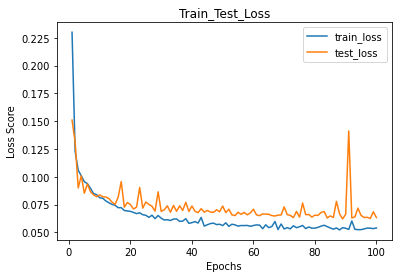

In [24]:
epochs = 100


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp03/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp03/sample_' + str(epoch) + '.png')
        

In [ ]:
epochs = 100


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp03/'+str(100+epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp03/sample_' + str(epoch) + '.png')
        